# Spritz MBHB search + imputation (time-domain approach)

Let's try to  replicate `MBHB-search-dev-globe.ipynb` with time-domain data and with Spritz data (MBHB-1 dataset).

E Castelli - 2022

## Table of contents

0. Settings and package import
1. Load time-domain LDC data
2. Build orthogonal TDI combinations
3. Data pre-processing before gap-imputation
4. Gap imputation with custom gaps
    1. noise-only `n` data
    2. noise + signal `n + s` data
5. Analysis of Spritz data

## 0. Settings and package import

In [1]:
# Python standard packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from cycler import cycler
import scipy.signal
import h5py
import time
import sys
from pyfftw.interfaces.numpy_fft import fft, ifft
from scipy import interpolate
from scipy import optimize



In [2]:
# Custom LISA Data Analysis packages 
from ldc.lisa.noise import get_noise_model
from ldc.common.tools import window

import lisabeta.lisa.ldcnoise as ldcnoise
from bayesdawn import datamodel, psdmodel
import lisaorbits

MLDC modules could not be loaded.


In [3]:
# define function to print all attributes of hdf5 file recursively
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. In order to do that, we separate the effect of glitches from the effect of gaps in the Spritz data.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [4]:
# import data
fname = '../data/LDC2_spritz_mbhb1_training_v2.h5'
# open file with h5py
fid = h5py.File(fname)
# print all dataset attributes
# fid.visititems(print_attrs)
cfg = dict(zip(fid["obs/config"].keys(), [v[()] for v in fid["obs/config"].values()]))

#### 1.1. Import LDC data
Import the existing TDI datasets and build the missing TDI dataset

Existing:
- TDI dataset `obs` containing `noise + signal + artifacts` (gaps + glitches)
- TDI dataset `clean` containing `noise + signal`
- TDI dataset `sky` containing `signal`
- TDI dataset `noisefree` containing `signal + artifacts` (gaps + glitches)

Missing:
- TDI dataset containing `noise`
- TDI dataset containing `noise + signal + gaps`

In [5]:
from bayesdawn.connect.fillgaps import load_tdi_timeseries

In [6]:
tdidata = load_tdi_timeseries(fname = fname)

In [7]:
# set up dataset constant values
skip = 100 
# skipb = 100 
ndata = len(tdidata['obs'][skip:])
dt = tdidata['obs']['t'][1]-tdidata['obs']['t'][0]
fs = 1.0/dt

# print('skip','ndata','dt', 'fs',sep='\t',end='\n------------------------------\n')
# print(skip, ndata, dt, fs,sep='\t')

#### 1.3. Plot imported data:
- Datasets containing NO noise artifacts: `n+s`, `s`, `n`
- Dataset with artifacts: `n+s+g+gl`, `n+s+g`,`s+g+gl`
    
Useful LDC-provided resources and code bits to importing Spritz data taken from here: https://gitlab.in2p3.fr/LISA/LDC/-/blob/develop/notebooks/LDC2b-Spritz.ipynb

In [8]:
# avgwin = 'nuttall'
avgwin = 'hann'

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

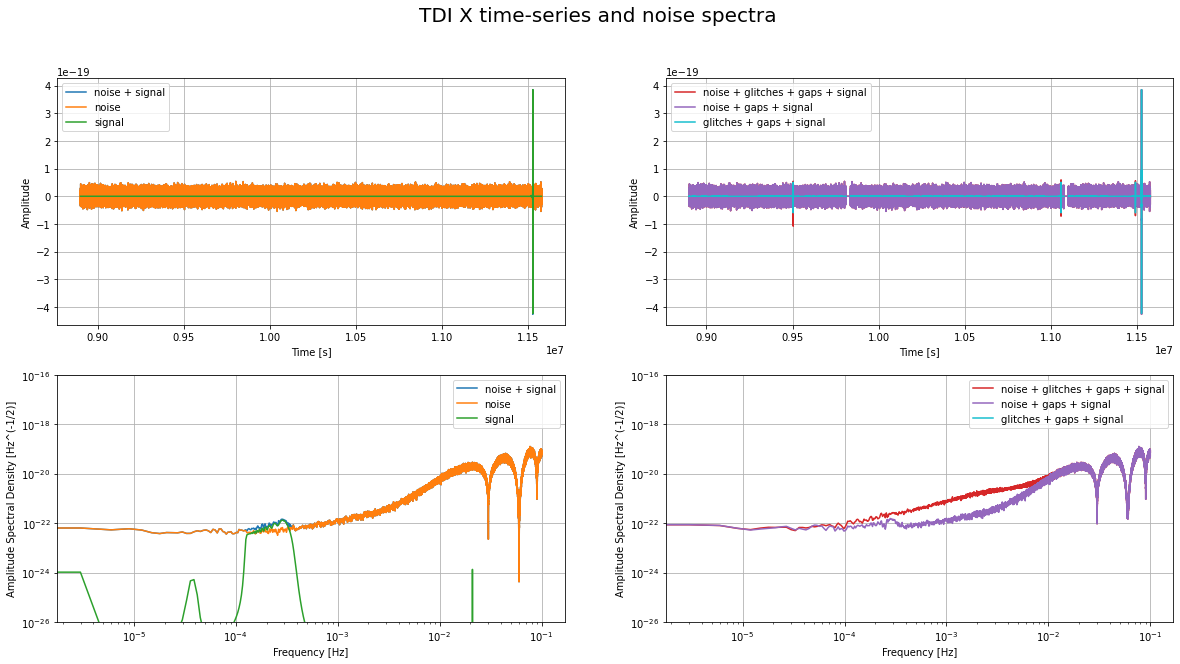

In [9]:
# plot TDI X time-series and noise spectra for all different configurations
nperseg=ndata//8
fig, ax = plt.subplots(2, 2, figsize=(20,10))
# top left canvas
ax[0][0].plot(tdidata['clean']['t'][skip:], tdidata['clean']["X"][skip:], label = 'noise + signal')
ax[0][0].plot(tdidata['noise']['t'][skip:], tdidata['noise']["X"][skip:], label='noise')
ax[0][0].plot(tdidata['sky']['t'][skip:], tdidata['sky']["X"][skip:], label='signal')
ax[0][0].set_ylabel("Amplitude")
ax[0][0].set_xlabel("Time [s]")
ax[0][0].grid()
ax[0][0].legend()
# top right canvas
ax[0][1].plot(tdidata['obs']['t'][skip:], tdidata['obs']["X"][skip:], label='noise + glitches + gaps + signal', color='tab:red')
ax[0][1].plot(tdidata['clean_gapped']['t'][skip:], tdidata['clean_gapped']["X"][skip:], label='noise + gaps + signal', color='tab:purple')
ax[0][1].plot(tdidata['noisefree']['t'][skip:], tdidata['noisefree']["X"][skip:], label='glitches + gaps + signal', color='tab:cyan')
ax[0][1].set_ylabel("Amplitude")
ax[0][1].set_xlabel("Time [s]")
ax[0][1].grid()
ax[0][1].legend()
# bottom left canvas
f, psdX =  scipy.signal.welch(tdidata['clean']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise + signal')
f, psdX =  scipy.signal.welch(tdidata['noise']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise')
f, psdX =  scipy.signal.welch(tdidata['sky']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'signal')
ax[1][0].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][0].set_xlabel("Frequency [Hz]")
ax[1][0].grid()
ax[1][0].legend()
ax[1][0].set_ylim([1e-26,1e-16])
# ax[1][0].set_xlim([2e-5,0.3])

# bottom right canvas
tdix_wo_nan = tdidata['obs']["X"].copy()
tdix_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdix_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + glitches + gaps + signal', color='tab:red')

tdigapped_wo_nan = tdidata['clean_gapped']["X"].copy()
tdigapped_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdigapped_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + gaps + signal', color='tab:purple')

tdinoise_wo_nan = tdidata['noisefree']["X"].copy()
tdinoise_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdinoise_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'glitches + gaps + signal', color='tab:cyan')

ax[1][1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][1].set_xlabel("Frequency [Hz]")
ax[1][1].grid()
ax[1][1].legend()
ax[1][1].set_ylim([1e-26,1e-16])
# ax[1][1].set_xlim([2e-5,0.3])

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)
# fig.tight_layout()

## 2. Build orthogonal TDI combinations

### 2.1. Build orthogonal TDI combinations for `n+s` data. 

Check that explicit evaluation of orthogonal TDI combinations is equivalent to evaluation inside LDC functions.

In [10]:
from bayesdawn.connect.fillgaps import build_orthogonal_tdi

In [11]:
datans = build_orthogonal_tdi(tdidata['clean'])

Compare my evaluation to LDC conversion function, just to be on the safe side of things.

### 2.2. Build orthogonal TDI combinations for `s`, `n`, `n+s+g` data. 


In [12]:
datas  = build_orthogonal_tdi(tdidata['sky'])
datan  = build_orthogonal_tdi(tdidata['noise'])
datag  = build_orthogonal_tdi(tdidata['clean_gapped'])
datang = build_orthogonal_tdi(tdidata['noise_gapped'])
dataobs = build_orthogonal_tdi(tdidata['obs'])

### 2.3. Define useful functions 

All these will end up in a separate file afterwards.

- `fft_olap_psd`: function that evaluates PSD equivalent to `scipy.signal.welch` and also evaluates FFT at the same time
- `generate_freq_data`: function that applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
- `plot_compare_spectra_timeseries`: modified version of `lisabeta_fill_gaps.plot_compare_spectra` function that plots noise spectra and distribution of real/imag part of PSD/noise_model

### 2.4 Data quicklook
#### 2.4.1 Test PSD and FFT evaluation function

In [13]:
from bayesdawn.connect.fillgaps import fft_olap_psd, generate_freq_data, plot_compare_spectra_timeseries

#### 2.4.2 Define LISA noise model
Import noise model for Spritz data from LDC toolbox.

In [14]:
cfg['dt_orbits'], cfg['nominal_arm_length'], cfg['kepler_order']

(86400.0, 2500000000.0, 2)

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


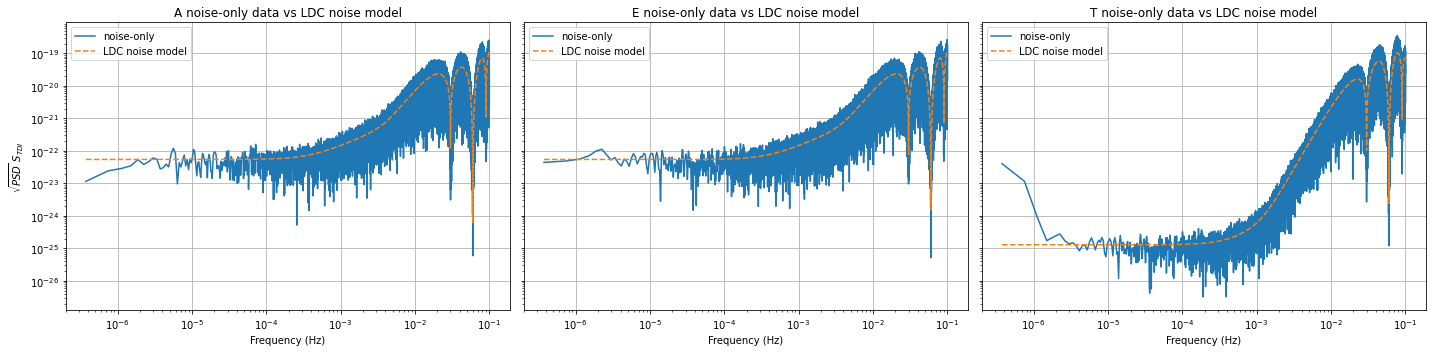

In [15]:
#Load some noise models from lisabeta
# import lisabeta.lisa.pyLISAnoise as pyLISAnoise

LISAnoise={'InstrumentalNoise': 'SciRDv1', 
           'WDbackground': False, 
           'WDduration': 0.0, 
           'lowf_add_pm_noise_f0': 0.0, 
           'lowf_add_pm_noise_alpha': 2.0}
# LISAnoise={'InstrumentalNoise': 'Proposal', 
#            'WDbackground': True, 
#            'WDduration': 3.0, 
#            'lowf_add_pm_noise_f0': 0.0, 
#            'lowf_add_pm_noise_alpha': 2.0}

# eval psd of noise data
fdatan, psddatan, fftscalefac = generate_freq_data(datan)
# noise models for A, E, T
 # Comparison with LISA Orbits
orbits = lisaorbits.KeplerianOrbits(dt=cfg['dt_orbits'], 
                                    L=cfg['nominal_arm_length'], 
                                    a=149597870700.0, 
                                    lambda1=0, 
                                    m_init1=0, 
                                    kepler_order=cfg['kepler_order'])
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan['f'], wd=0, orbits=orbits, t_obs=ndata*dt)
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan['f'], equal_arms=False)
# plot data
fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=True)
for tdi in S.keys(): 
    ax[list(S.keys()).index(tdi)].set_title('{tdi} noise-only data vs LDC noise model'.format(tdi=tdi))
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(psddatan[tdi]), label='noise-only')
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(S[tdi]), ls='--', label='LDC noise model')
    ax[list(S.keys()).index(tdi)].set_xlabel('Frequency (Hz)')
    ax[list(S.keys()).index(tdi)].grid()
    ax[list(S.keys()).index(tdi)].legend()

ax[0].set_ylabel(r'$\sqrt{PSD}$ $S_{TDI}$')
fig.tight_layout()
# plt.suptitle('Comparison between TDI of noise-only Spritz data vs noise models');

#### 2.4.3 Plot comparison between spectra and FFT distribution

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


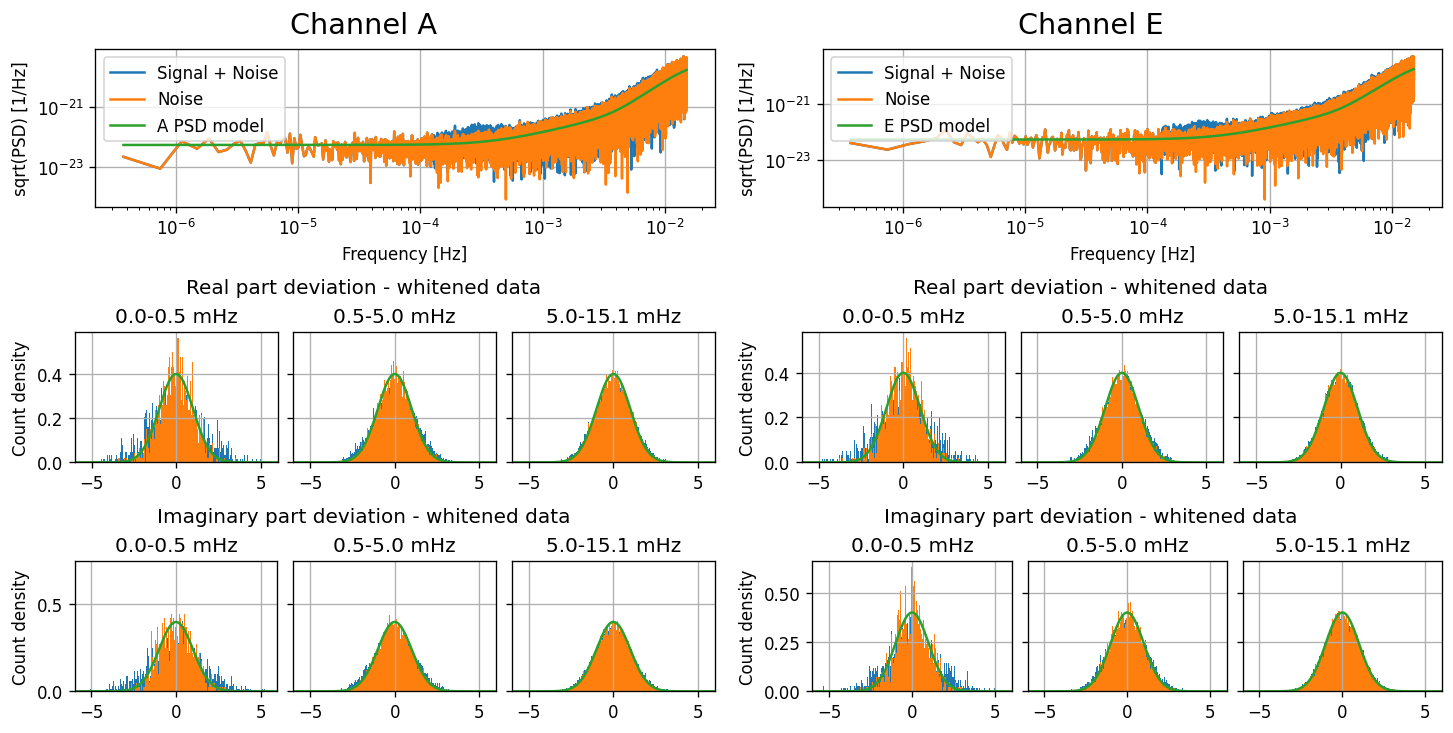

In [16]:
fmax = 1.51e-2
plot_compare_spectra_timeseries(data = [datans, datan], 
                                freq_bands=[5e-4, 5e-3],
                                fmax = fmax)

## 3. Spritz data gaps in noise only data `n + g`

In [17]:
# import lisabeta_fill_gaps as fill_gaps
from bayesdawn.connect.fillgaps import construct_gap_mask

Here we compare the full noise + signal dataset with the only-noise dataset, applying `LISAnoise` as noise model for the TDI noise spectra.

We'll first apply imputation to noise-only `n` data in the `datan` dataset.

For gapped data we'll be using the `datang` dataset, containing the Sprtiz noise-only data with gaps `n + g`.


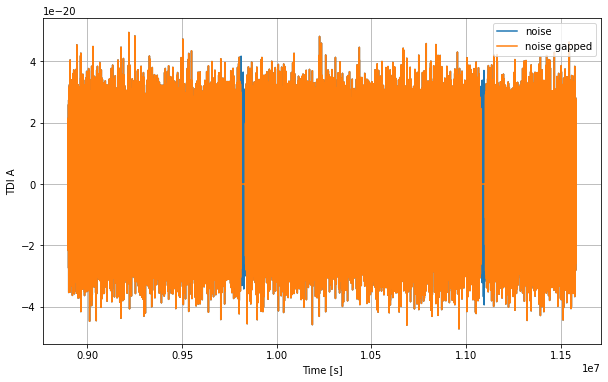

In [18]:
# compare noise full data and noise gapped data
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# top left canvas
ax.plot(datan['t'], datan['A'], label='noise')
ax.plot(datang['t'], datang['A'], label='noise gapped')
ax.set_xlabel('Time [s]')
ax.set_ylabel('TDI A')
ax.grid()
ax.legend()

In [19]:
# reset time-series information data
ndata = datang.shape[0]
dt = datang['t'][1]-datang['t'][0]
fs = 1/(datang['t'][1]-datang['t'][0])

print('ndata','dt', 'fs',sep='\t',end='\n---------------------\n')
print(ndata, dt, fs,sep='\t')

fdatan, psddatan, fftscalefac = generate_freq_data(datan)
fdatang, psddatang, fftscalefac = generate_freq_data(datang)

ndata	dt	fs
---------------------
535580	5.0	0.2


### 3.1 Set up PSD Spritz noise model

We'll end up not using this noise model in the gap imputation, but this might be useful for other purposes (or once the Spritz noise model is fixed).

In [20]:
from bayesdawn.connect.fillgaps import LDCModelPSD

Let's take a look at the model w.r.t downaveraged data.

We also need to generate the Spritz gap mask.

In [21]:
from bayesdawn.connect.fillgaps import get_ldc_gap_mask

In [22]:
mask = np.ones(datang.shape[0])
ndata = datang.shape[0]

spritzgaps = get_ldc_gap_mask(dataobs, mode='index')
gapstarts,gapends= np.vsplit(spritzgaps, 2)

for k in range(gapstarts.shape[1]):
    mask[gapstarts.reshape((2))[k]:gapends.reshape((2))[k]]=0

spritzmask = {'mask': mask,
              'starts': gapstarts.reshape((2)),
              'ends': gapends.reshape((2))}

figname = 'figures/nodownavg_spritzgaps'

Text(0, 0.5, 'Spritz gap mask')

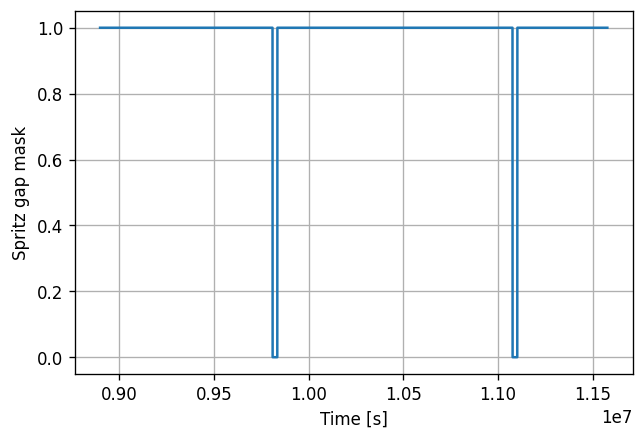

In [23]:
fig,ax = plt.subplots(1,1,dpi=120)
# ax.plot(maskinfo['mask'])
ax.plot(datan['t'],spritzmask['mask'])
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Spritz gap mask')

### 3.2 Visualize gaps in time-domain

Slightly modified version of `lisabeta_fill_gaps.view_gaps`.

In [24]:
from bayesdawn.connect.fillgaps import view_gaps

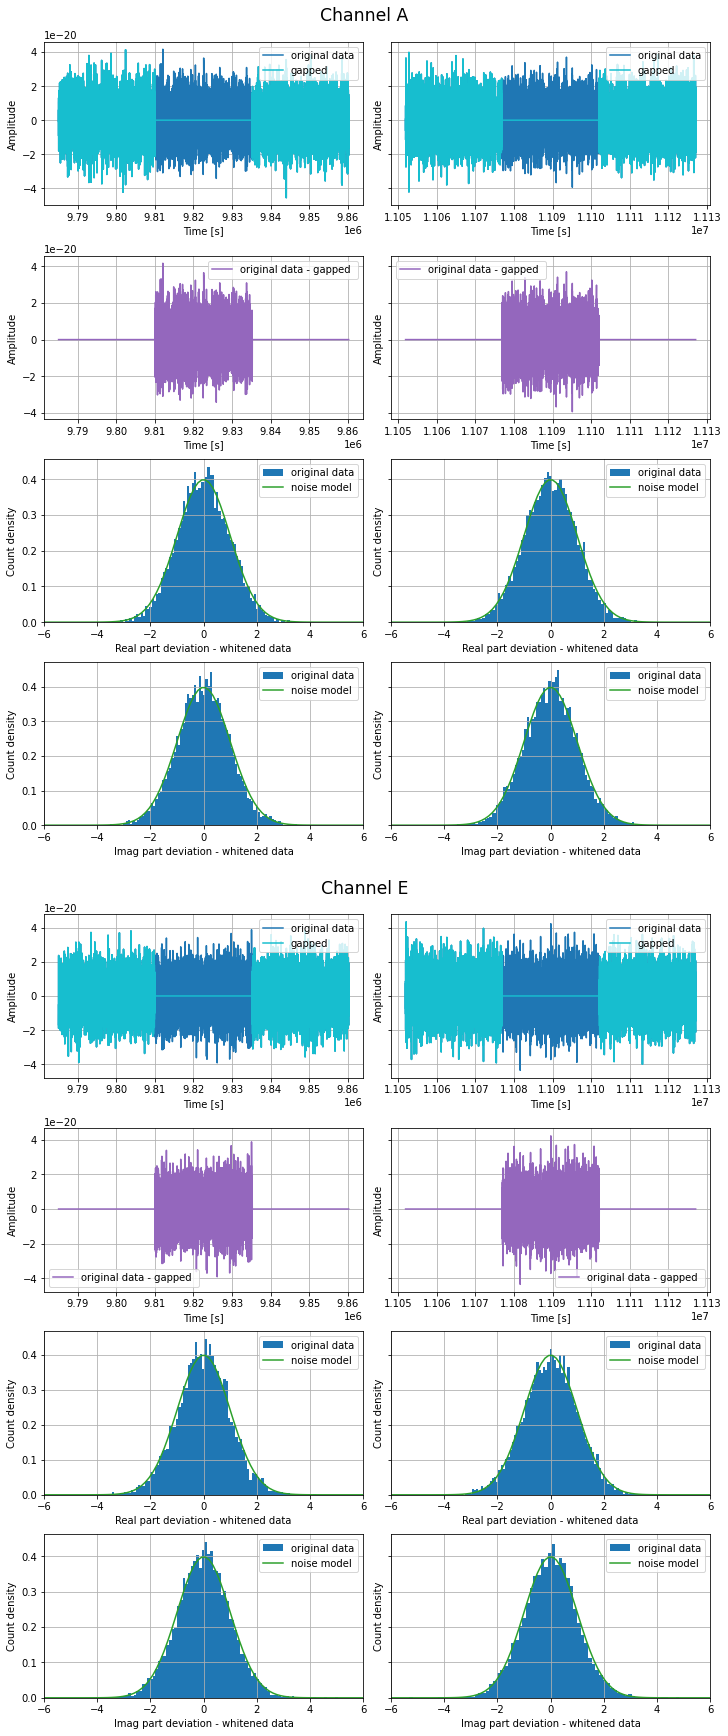

In [25]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datang.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data'], nwing = 5000, histogram=True)

### 3.3 Set up LDC noise model for PSD

In [26]:
# Embed the PSD function in a class
# psdmodel is imported from bayesdawn
class LDCModelPSD0(psdmodel.PSD):
    '''
    Specialization of the bayesdawn psd model class which connects LDC noise models to lisabeta PSD models.
    
    Parameters
    ----------
    n_data : array_like
        vector of size N_DSP continaing the noise DSP calculated at frequencies
        between -fe/N_DSP and fe/N_DSP where fe is the sampling frequency and N
        is the size of the time series (it will be the size of the returned
        temporal noise vector b)
    fs : scalar integer
        Size of the output time series
    noise_model : scalar float
        sampling frequency
    channel : string
        seed of the random number generator

    Returns
    -------
        bf : numpy array
        frequency sample of the colored noise (size N)
    '''

    def __init__(self, ndata, fs, noise_model, channel, fmin=None, fmax=None, config = cfg):
        # instantiates the PDS estimator from function psdmodel.PSD
        self.noise_model = noise_model
        self.channel = channel
        psdmodel.PSD.__init__(self, ndata, fs, fmin=None, fmax=None)
        if fmax is not None:
            self.f = self.f[self.f<fmax]

    def psd_fn(self, x):
        # returns the psd function defined earlier
        tobs = ndata / fs
        orbits = lisaorbits.KeplerianOrbits(dt=cfg['dt_orbits'], 
                                    L=cfg['nominal_arm_length'], 
                                    a=149597870700.0, 
                                    lambda1=0, 
                                    m_init1=0, 
                                    kepler_order=cfg['kepler_order']) 
        
        Nmodel = get_noise_model(self.noise_model, x, wd=0, orbits=orbits, t_obs=tobs)
        return Nmodel.psd(tdi2=True, option=self.channel, freq=x, equal_arms=False)

## 4. Perform data imputation with only LDC noise model

In [27]:
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []

names=['A', 'E', 'T']
# set up flags and variables
mask = spritzmask['mask']
datang_rec = datang.copy()
    
# instantiate the PSD noise class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))

(0.0, 200.0)

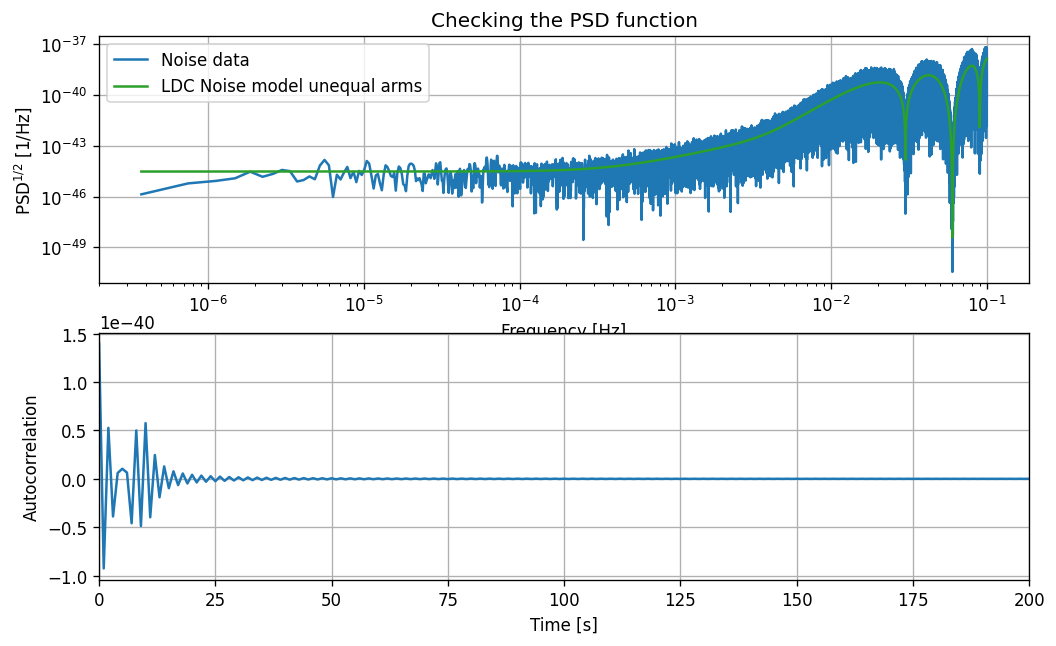

In [28]:
# Plot data against PSD
fig, ax = plt.subplots(2, 1, figsize=(10,6),dpi=120)
ax[0].set_title(r"Checking the PSD function")
ax[0].set_xlabel(r"Frequency [Hz]")
ax[0].set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
ax[0].loglog(psddatan['f'], (psddatan['A']), label="Noise data")
ax[0].loglog(psddatan['f'], psd_cls[0].psd_fn(psddatan['f']), label="LDC Noise model unequal arms", color='tab:green')
# ax.loglog(psddatang['f'], (psddatang['A']), label="Noise")
ax[0].grid()
ax[0].legend()

# look at the psd autocorrelation to assess the width of the nearest region
ax[1].plot(psd_cls[0].calculate_autocorr(ndata))
ax[1].grid()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Autocorrelation')
ax[1].set_xlim([0, 200])

In [29]:
# Perform data imputation WITHOUT loop
### NB this can be streamlined a little bit more and/or transformed into a function 
for tdi in range(len(names)):
    t1 = time.time()
    y_masked = datang[names[tdi]]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # instantiate imputation class
    imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='nearest', na=250, nb=250)]
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    # Don't update PSD
    imp_cls[tdi].update_psd(psd_cls[tdi])
    # Re-compute of PSD-dependent terms
    imp_cls[tdi].compute_offline()
    # Imputation of missing data by randomly drawing from their conditional distribution
    y_rec = imp_cls[tdi].impute(y_masked, draw=True)
    # Update the data residuals
    y_res = y_rec - s
    # Update the data residuals
    t2 = time.time()
    print("Imputation for combination " + names[tdi] + " took " + str(t2-t1))
    datang_rec[names[tdi]] = y_res

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/bayesdawn-0.1.0-py3.10.egg/bayesdawn/datamodel.py:340: UserWarning: The maximum size of gap + conditional is high.


Computation of autocovariance + PSD took 7.116821050643921
Imputation for combination A took 7.294536113739014
Computation of autocovariance + PSD took 6.428673028945923
Imputation for combination E took 6.586691856384277
Computation of autocovariance + PSD took 6.42617392539978
Imputation for combination T took 6.565323114395142


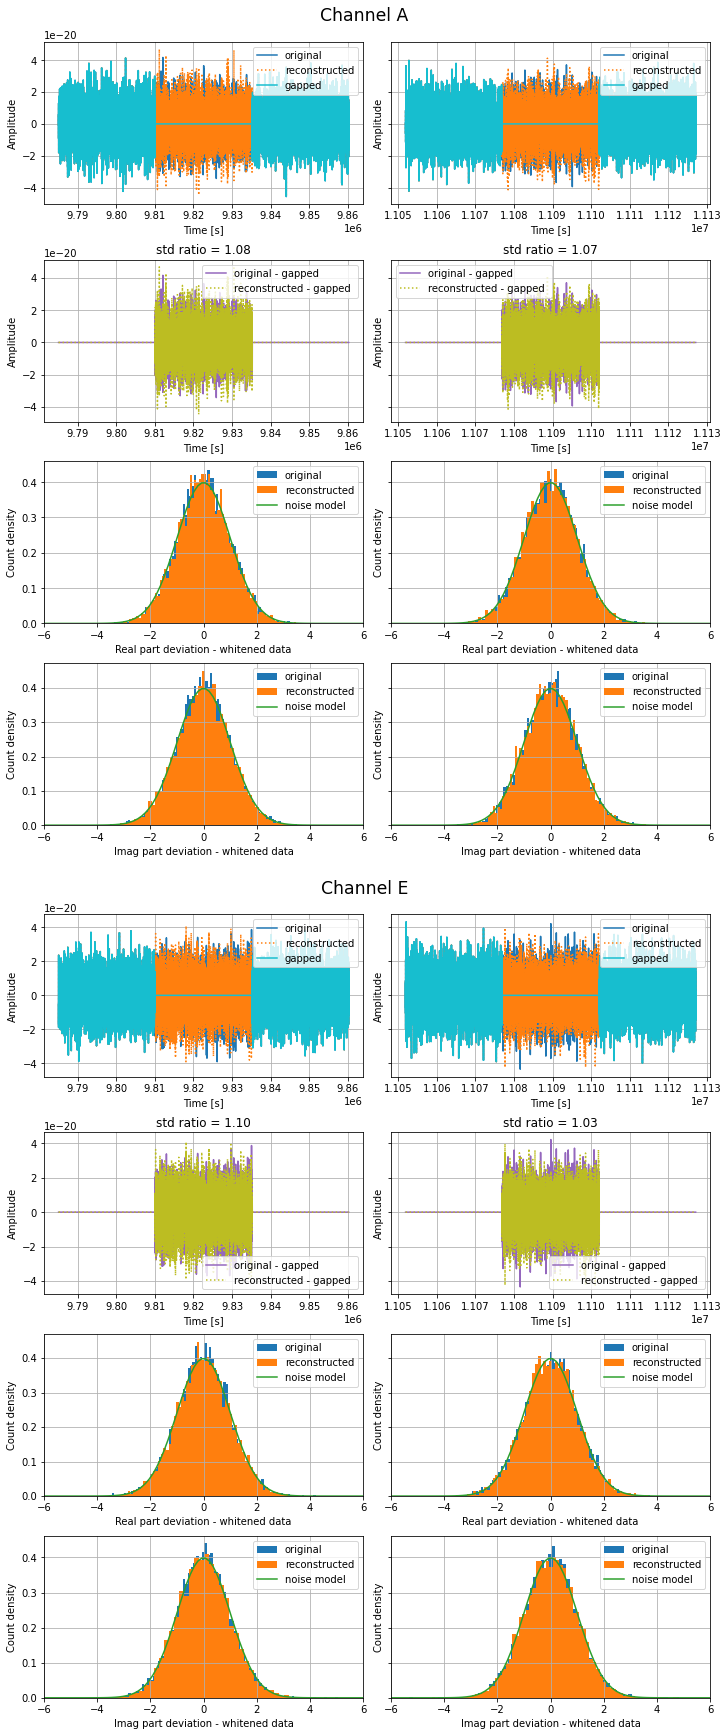

In [30]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original', 'reconstructed', 'gapped'],
          save = False, fname = figname, nwing=5000)

In [31]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

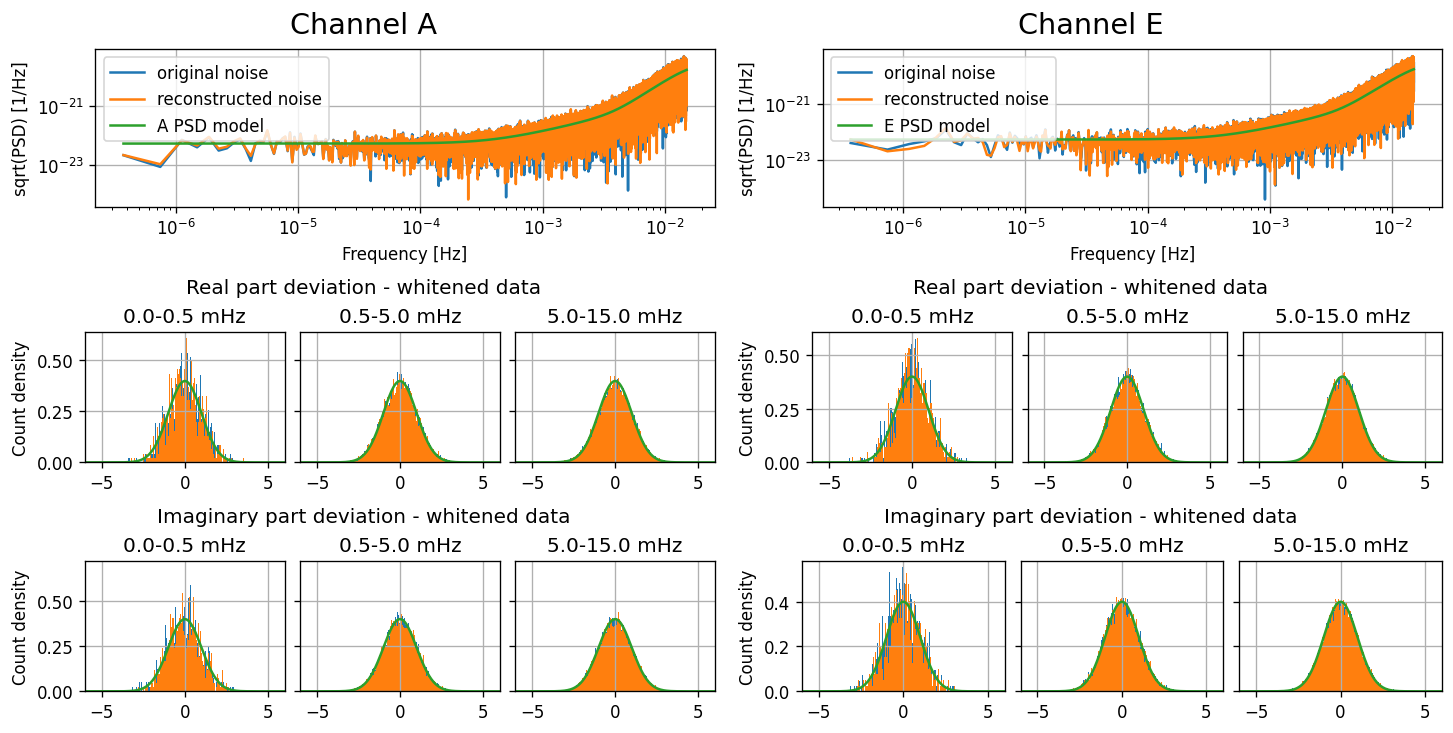

In [32]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec],
                                fmax = 1.5e-2, freq_bands=[5e-4, 5e-3],
                               labels = ['original noise', 'reconstructed noise'], 
                                save = False, fname = figname)

## 5. Perform data imputation with freq-domain PSD estimation

In [33]:
from bayesdawn import datamodel, psdmodel

### 5.1 Import PSD freq domain estimation tool
Import John's frequency domain PSD estimation tool.

In [34]:
import bayesdawn.connect.fillgaps as fillgaps
from bayesdawn.connect.fillgaps import makeFDdata


### 5.2 PSD estimated with `fit_type=None`

 `fmin` value is 3.73e-07
Instantiate imputation class for tdi channel A
Computation of autocovariance + PSD took 7.040677309036255
Computation of autocovariance + PSD took 0.212141752243042
Computation of autocovariance + PSD took 0.20150494575500488
Computation of autocovariance + PSD took 0.21317791938781738
Computation of autocovariance + PSD took 0.21867609024047852
Computation of autocovariance + PSD took 0.21118617057800293
Computation of autocovariance + PSD took 0.21062612533569336
Imputation for combination A took 12.97774600982666
Instantiate imputation class for tdi channel E
Computation of autocovariance + PSD took 7.447387933731079
Computation of autocovariance + PSD took 0.22435617446899414
Computation of autocovariance + PSD took 0.2303180694580078
Computation of autocovariance + PSD took 0.22195672988891602
Computation of autocovariance + PSD took 0.2267589569091797
Computation of autocovariance + PSD took 0.2284398078918457
Computation of autocovariance + PSD took 0.2

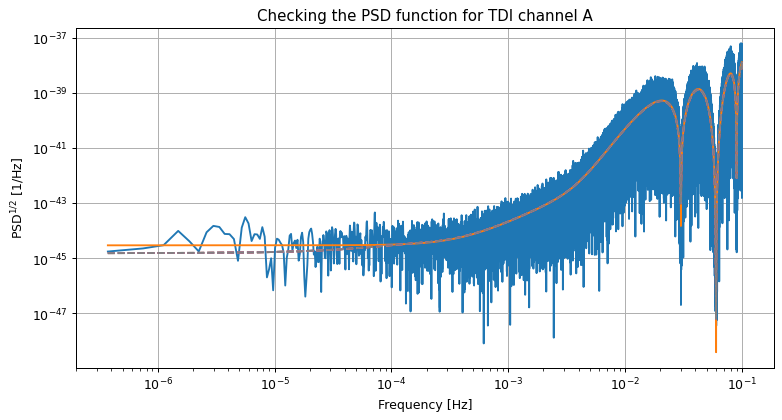

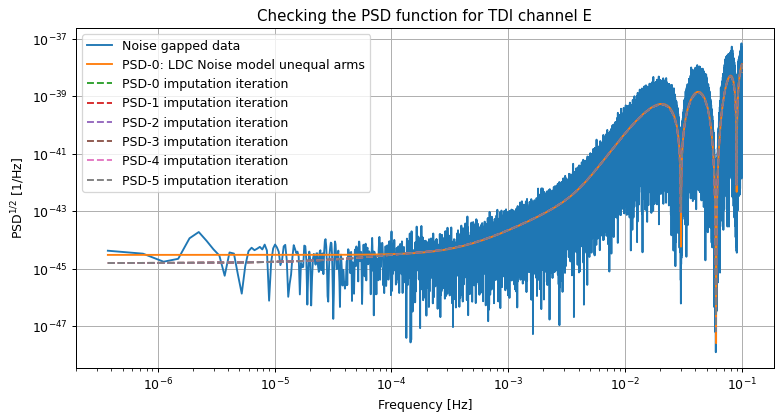

In [35]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 6

# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 1
print(' `fmin` value is {:.2e}'.format(fmin))
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation
for tdi in names:
    t1 = time.time()
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', 
                                                       na=100, nb=100))
#     print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise gapped data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="PSD-0: LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
#     print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
#     print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
#         print('Imputation iteration '+str(i))

        # Do update PSD
#         print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = psdmodel.ModelFDDataPSD
#         print('\t Instantiate PSD estimator') 
        save_stdout = sys.stdout
        sys.stdout = open('trash', 'w')
        
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type=None,#'log_spline',fit_dof=14,
                          smooth_df=4e-4,
                          fmin=psddatang['f'][0])
        sys.stdout = save_stdout
#         print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        
        ax.loglog(psdmod.f[psdmod.f>0], (psdmod.psd_fn(psdmod.f[psdmod.f>0])), ls='--', label='PSD-'+str(i)+' imputation iteration')
        # Re-compute of PSD-dependent terms
#         print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
#         print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_masked, draw=True)
        # Update the data residuals
#         print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='upper left')
ax.grid()

ax.grid()

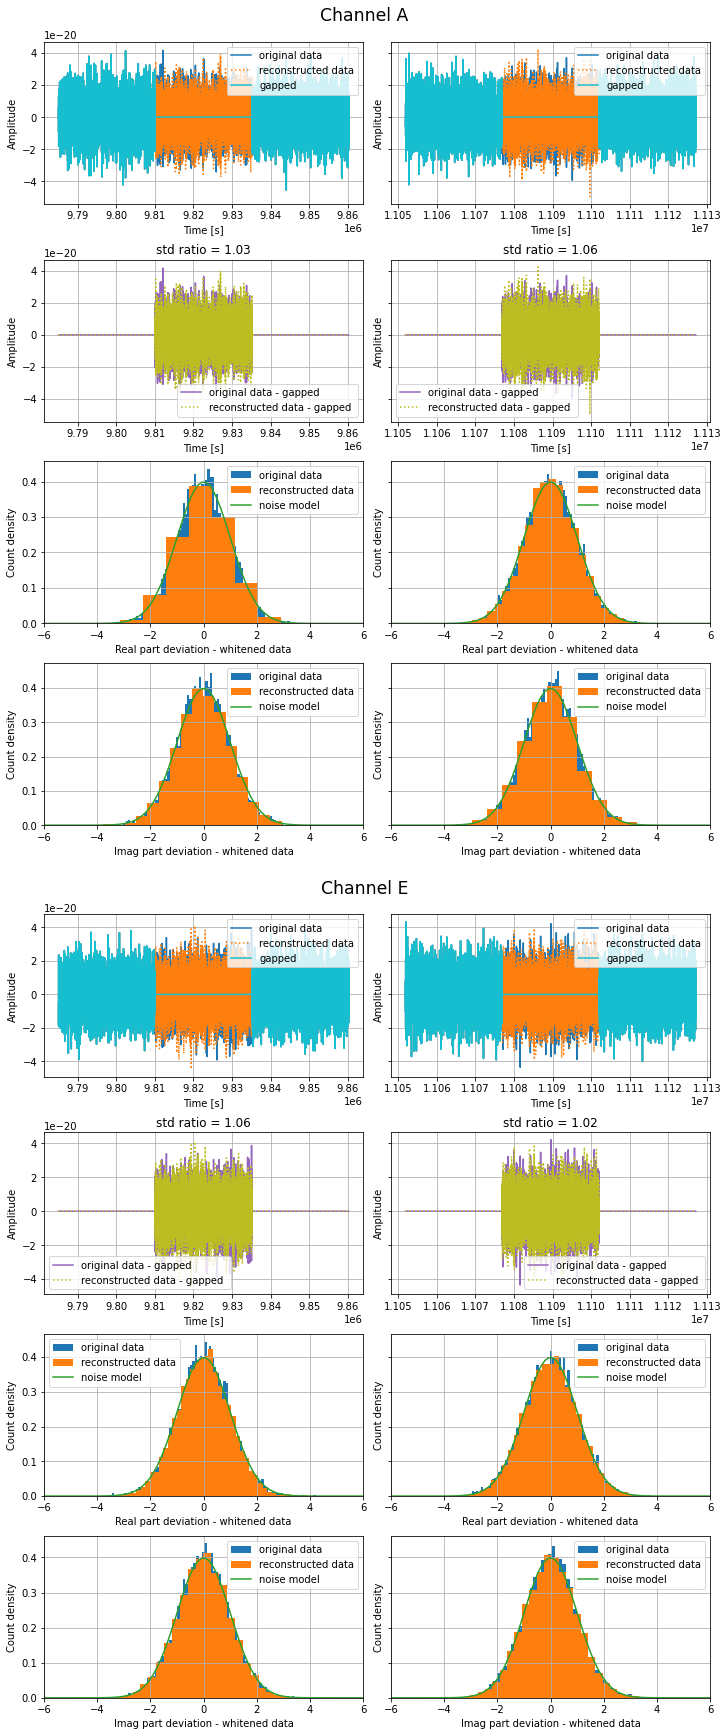

In [36]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

In [37]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

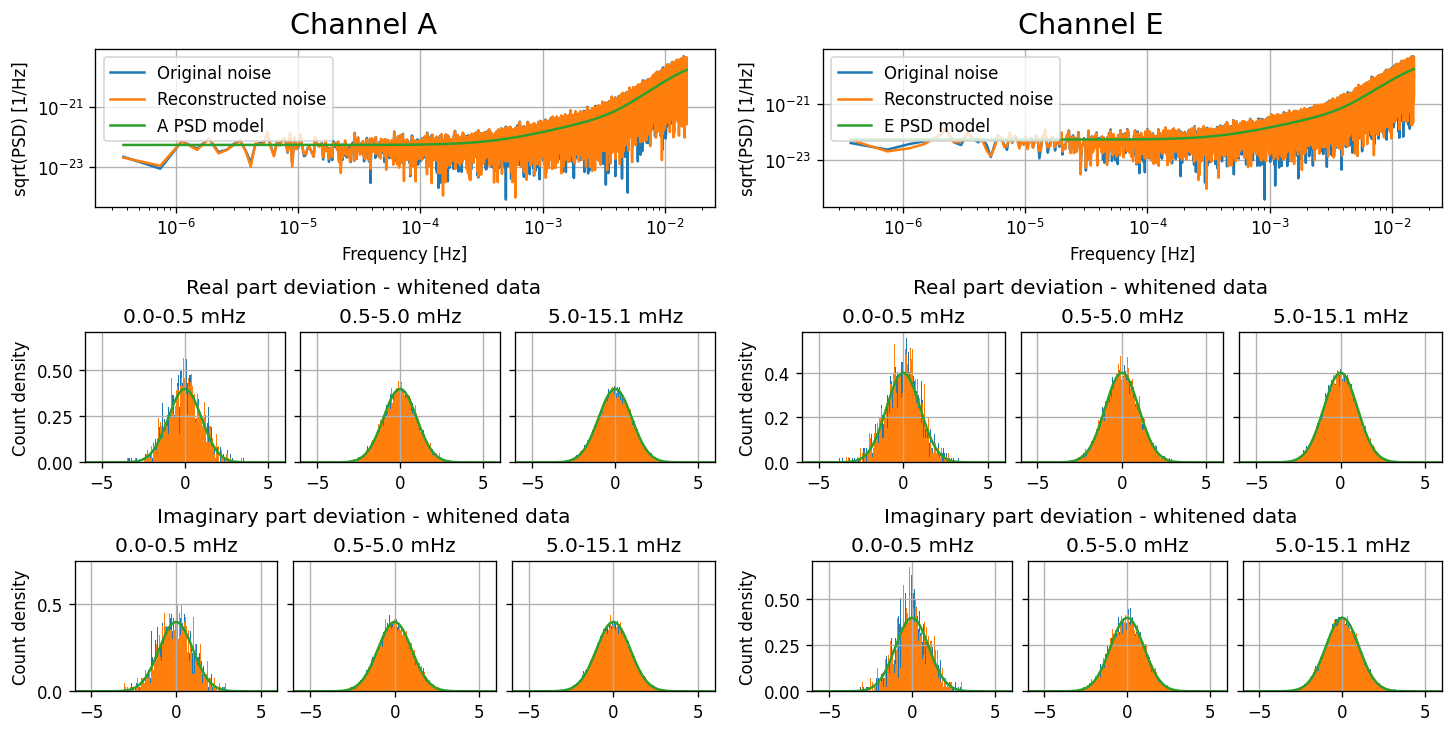

In [38]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmax = 1.51e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

### 5.3 PSD estimated with `fit_type='log_spline`
#### Test 1: `fit_dof=6`, `fmin = f[0]`, `n_iter=10`

 `fmin` value is 3.73e-07
Instantiate imputation class for tdi channel A
Computation of autocovariance + PSD took 7.649605989456177
Computation of autocovariance + PSD took 0.24707818031311035
Computation of autocovariance + PSD took 0.2614271640777588
Computation of autocovariance + PSD took 0.2280580997467041
Computation of autocovariance + PSD took 0.23470115661621094
Computation of autocovariance + PSD took 0.2171461582183838
Computation of autocovariance + PSD took 0.2527008056640625
Computation of autocovariance + PSD took 0.2656388282775879
Computation of autocovariance + PSD took 0.24540090560913086
Computation of autocovariance + PSD took 0.2261049747467041
Computation of autocovariance + PSD took 0.23926138877868652
Imputation for combination A took 16.98112726211548
Instantiate imputation class for tdi channel E
Computation of autocovariance + PSD took 6.907900094985962
Computation of autocovariance + PSD took 0.23925113677978516
Computation of autocovariance + PSD took 0.22

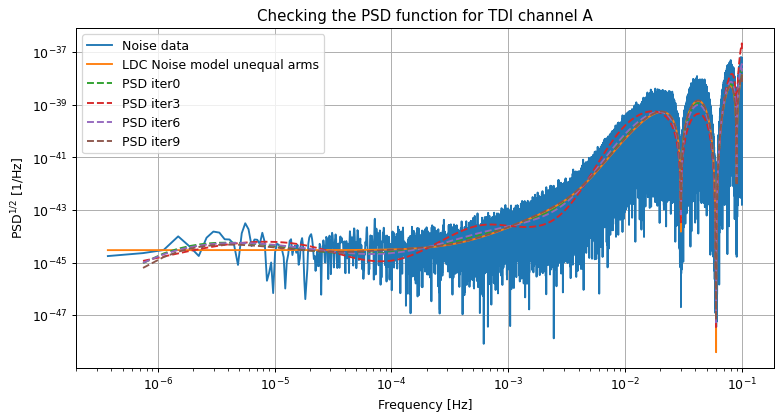

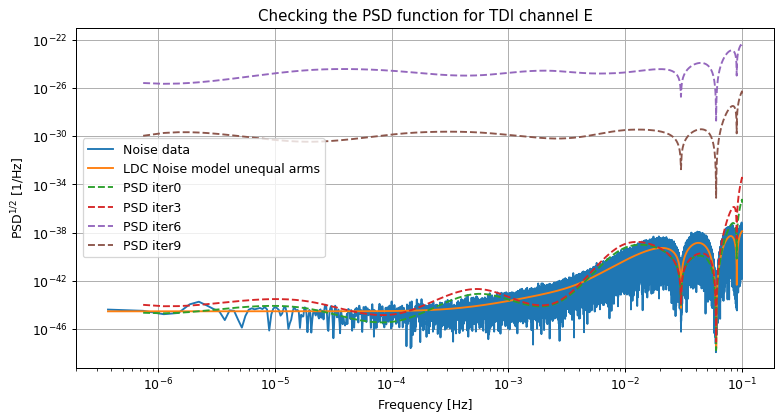

In [39]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10

# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 1
print(' `fmin` value is {:.2e}'.format(fmin))
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
#     print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    
#     print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
#     print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
#         print('Imputation iteration '+str(i))

        # Do update PSD
#         print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = psdmodel.ModelFDDataPSD
#         print('\t Instantiate PSD estimator') 
        save_stdout = sys.stdout
        sys.stdout = open('trash', 'w')
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type='log_spline',
                          fit_dof=6,
                          smooth_df=4e-4,
                          fmin=fmin,
                          offset_log_fit=True)
        sys.stdout = save_stdout

#         print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
        # Re-compute of PSD-dependent terms
#         print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
#         print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
        # Update the data residuals
#         print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))
ax.legend(loc='best')
ax.grid()

ax.grid()

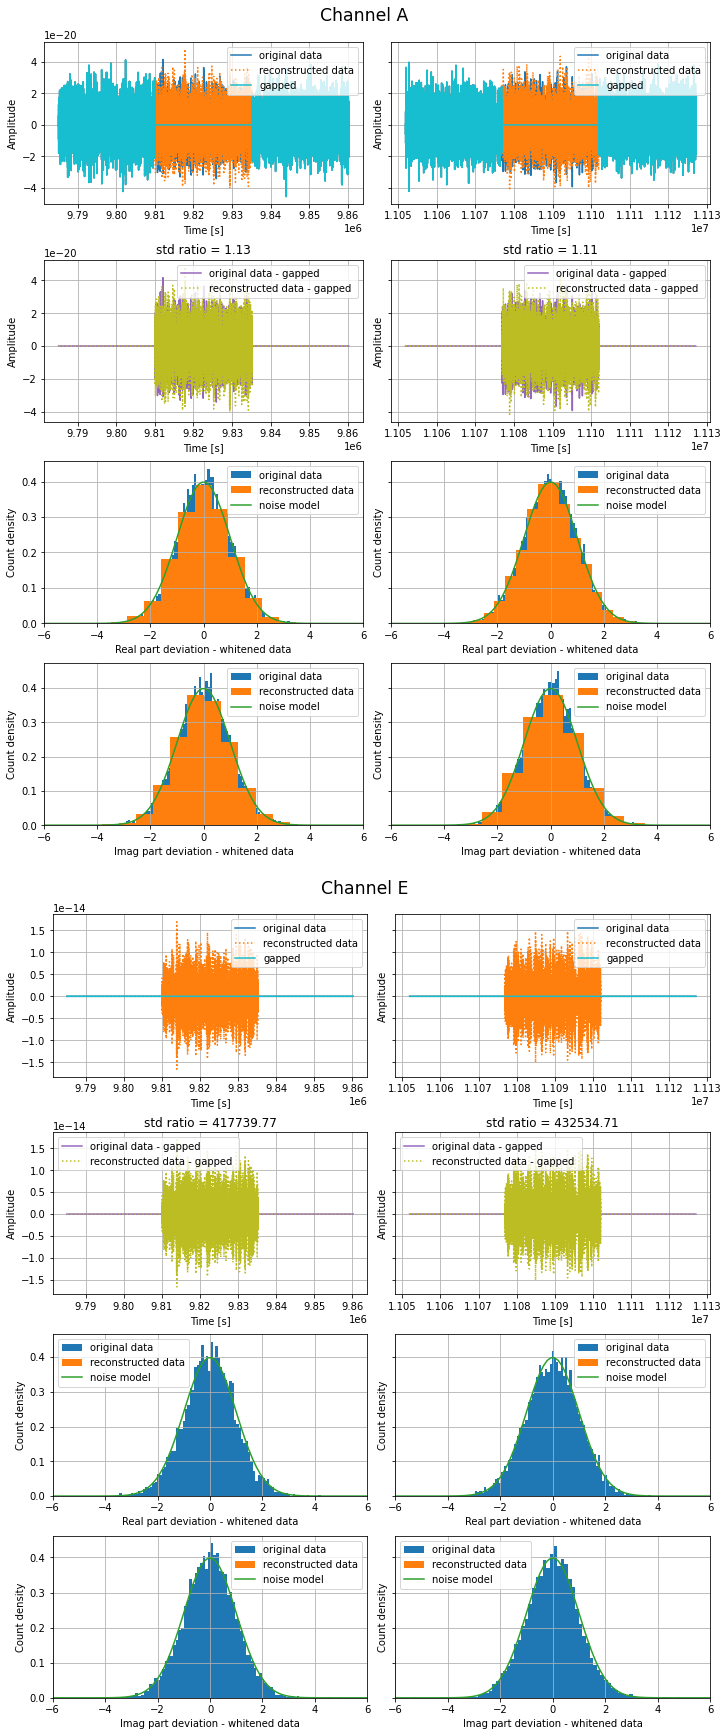

In [40]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

In [41]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

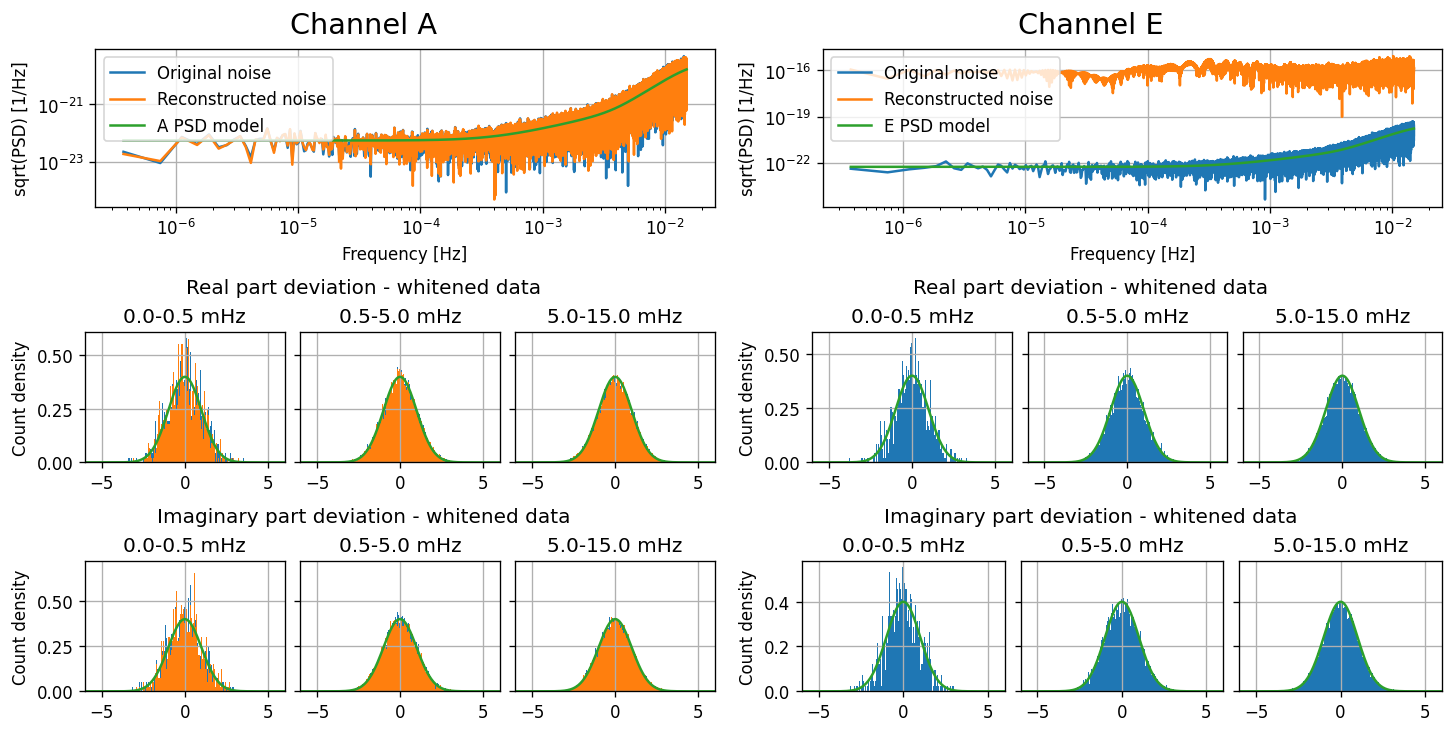

In [42]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 2: `fit_dof=15`, `fmin = f[0]`, `n_iter=10`

 `fmin` value is 3.73e-07
Instantiate imputation class for tdi channel A
Computation of autocovariance + PSD took 7.956135988235474
Computation of autocovariance + PSD took 0.22916293144226074
Computation of autocovariance + PSD took 0.22182512283325195
Computation of autocovariance + PSD took 0.22947216033935547
Computation of autocovariance + PSD took 0.2212378978729248
Computation of autocovariance + PSD took 0.24680399894714355
Computation of autocovariance + PSD took 0.24095392227172852
Computation of autocovariance + PSD took 0.24551677703857422
Computation of autocovariance + PSD took 0.24161195755004883
Computation of autocovariance + PSD took 0.2808699607849121
Computation of autocovariance + PSD took 0.23850202560424805
Imputation for combination A took 17.160461902618408
Instantiate imputation class for tdi channel E
Computation of autocovariance + PSD took 6.884843111038208
Computation of autocovariance + PSD took 0.2339940071105957
Computation of autocovariance + PSD took 

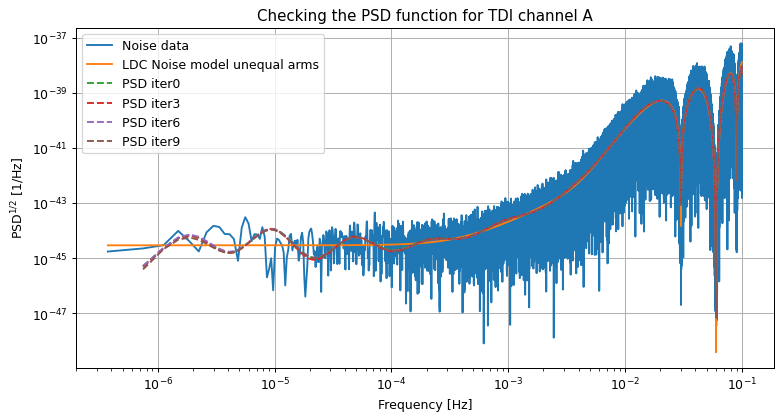

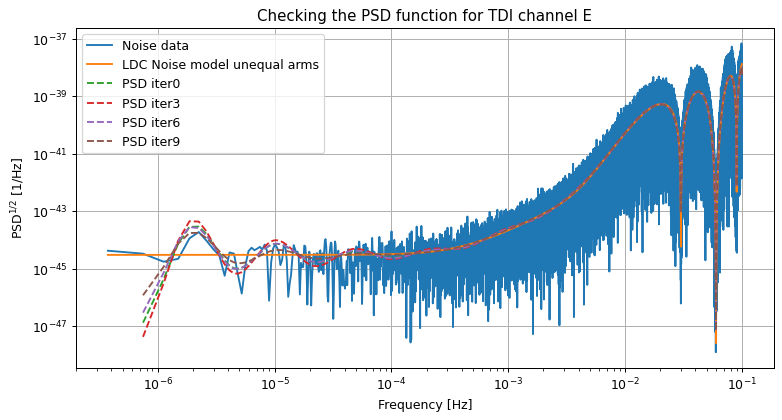

In [44]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10

# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 1
print(' `fmin` value is {:.2e}'.format(fmin))
# Upper frequency
fmax = fs/2

## initialize imputation

for tdi in names:
    t1 = time.time()
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
#     print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    
#     print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
#     print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
#         print('Imputation iteration '+str(i))
        # Do update PSD
#         print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = psdmodel.ModelFDDataPSD
#         print('\t Instantiate PSD estimator')   
        save_stdout = sys.stdout
        sys.stdout = open('trash', 'w')

        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type='log_spline',
                          fit_dof=15,
                          smooth_df=4e-4,
                          fmin=fmin,
                          offset_log_fit=True)
        sys.stdout = save_stdout

#         print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
        # Re-compute of PSD-dependent terms
#         print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
#         print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
        # Update the data residuals
#         print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
        t2 = time.time()
#         print("The imputation /  PSD estimation for combination " + tdi + " in iteration "+ str(i) +" took " + str(t2-t1))
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

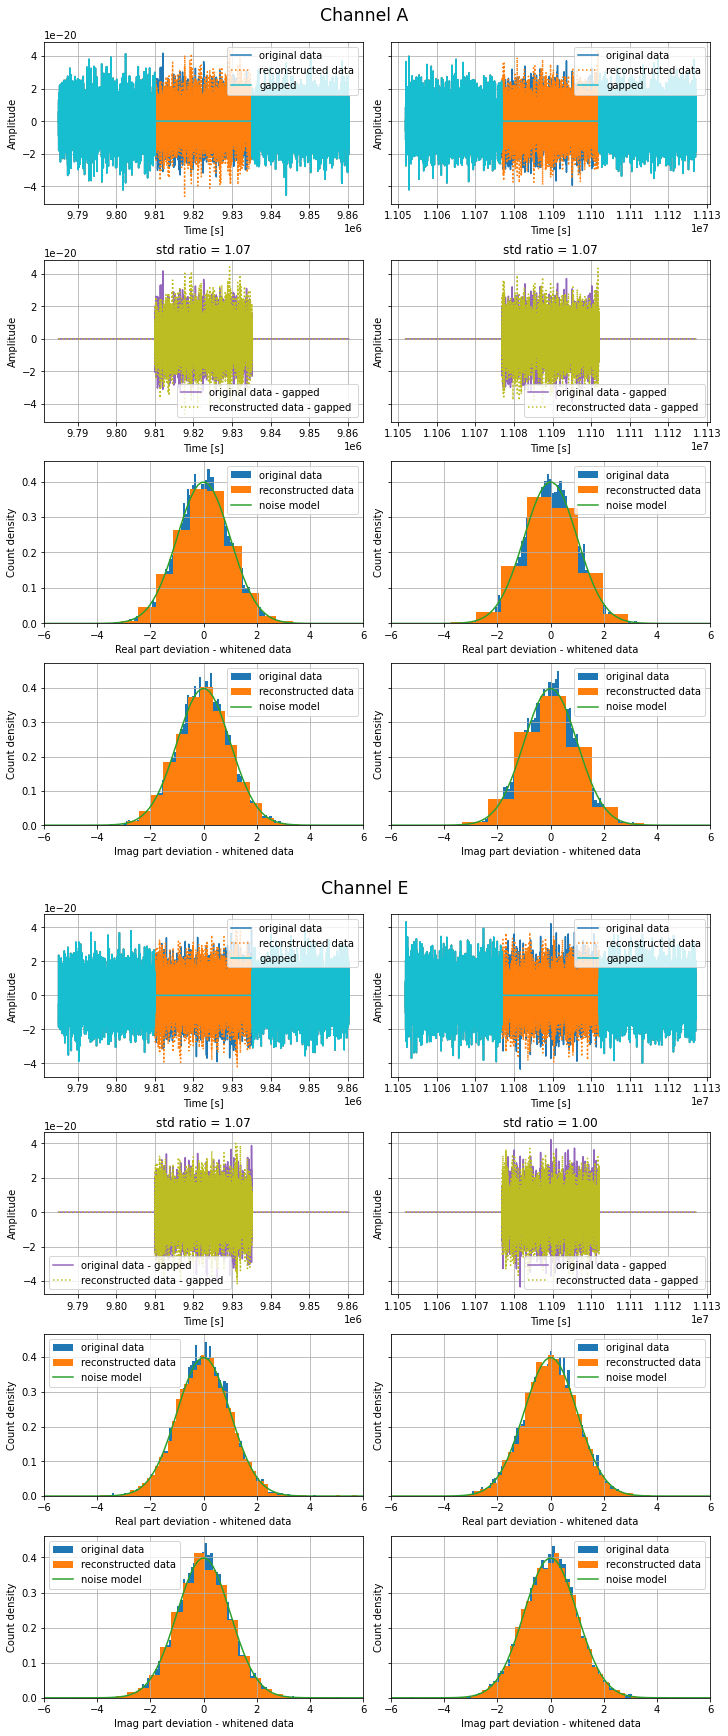

In [45]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

In [46]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

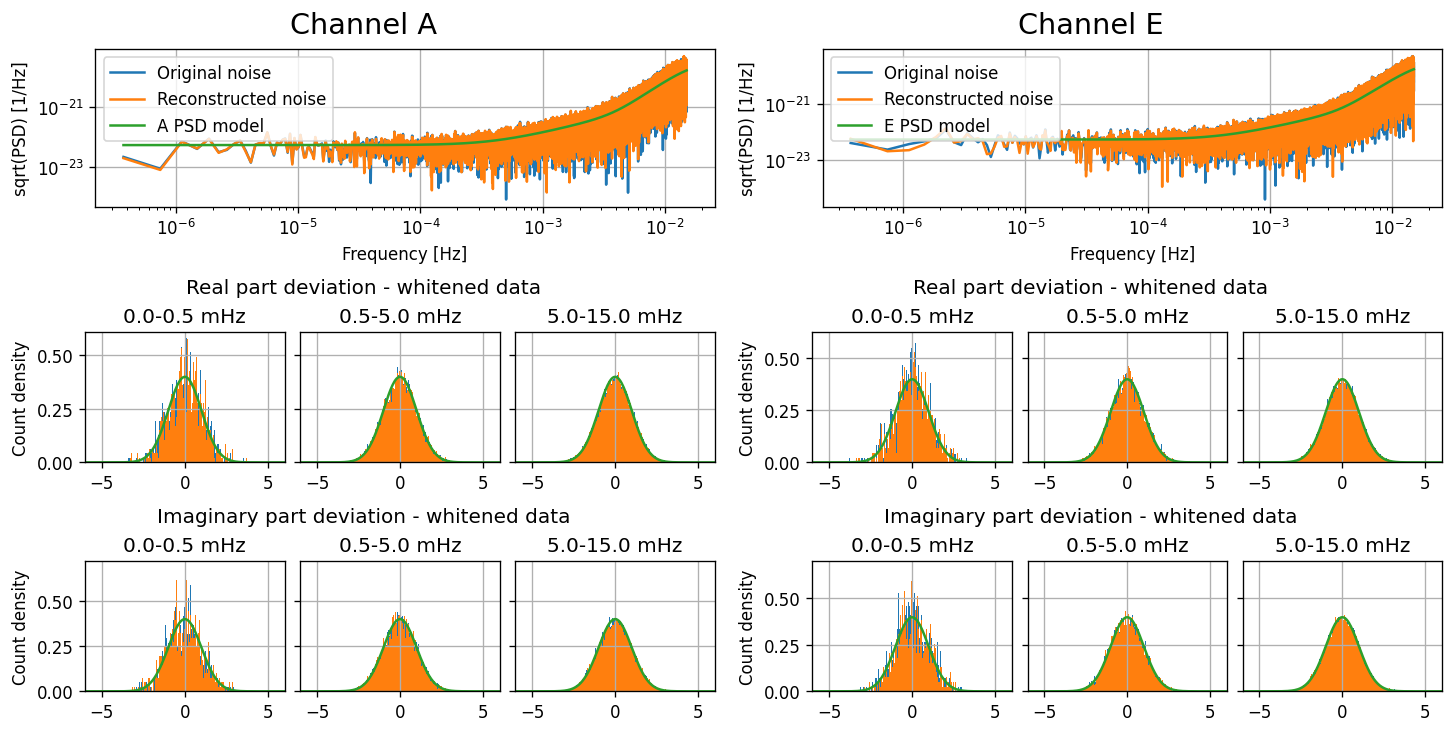

In [47]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 3: `fit_dof=30`, `fmin = f[0]`, `n_iter=10`

 `fmin` value is 3.73e-07
Instantiate imputation class for tdi channel A
Computation of autocovariance + PSD took 7.097850799560547
Computation of autocovariance + PSD took 0.23522305488586426
Computation of autocovariance + PSD took 0.23677515983581543
Computation of autocovariance + PSD took 0.22749900817871094
Computation of autocovariance + PSD took 0.2256309986114502
Computation of autocovariance + PSD took 0.2378988265991211
Computation of autocovariance + PSD took 0.22275900840759277
Computation of autocovariance + PSD took 0.22232794761657715
Computation of autocovariance + PSD took 0.2565340995788574
Computation of autocovariance + PSD took 0.24156975746154785
Computation of autocovariance + PSD took 0.22347593307495117
Instantiate imputation class for tdi channel E
Computation of autocovariance + PSD took 6.764889717102051
Computation of autocovariance + PSD took 0.23773598670959473
Computation of autocovariance + PSD took 0.2213609218597412
Computation of autocovariance + PS

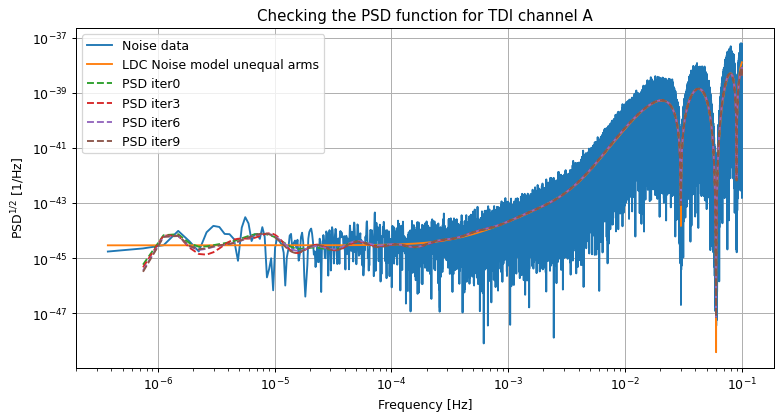

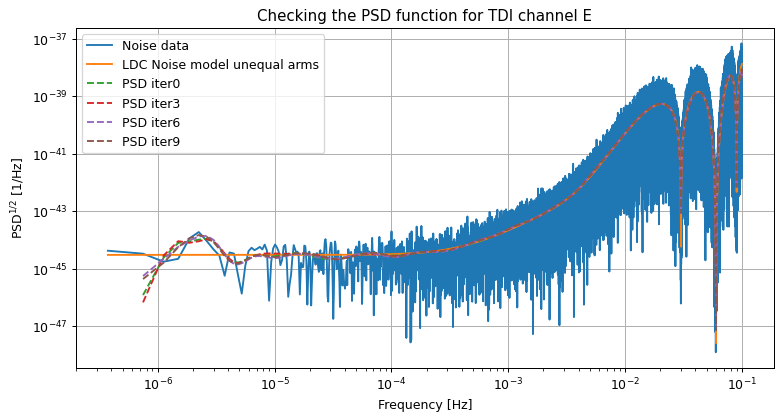

In [48]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10

# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 1
print(' `fmin` value is {:.2e}'.format(fmin))
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
#     print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    
#     print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
#     print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
#         print('Imputation iteration '+str(i))
        # Do update PSD
#         print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = psdmodel.ModelFDDataPSD
#         print('\t Instantiate PSD estimator') 
        save_stdout = sys.stdout
        sys.stdout = open('trash', 'w')
        
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type='log_spline',
                          fit_dof=30,
                          smooth_df=4e-4,
                          fmin=fmin,
                          offset_log_fit=True)
        sys.stdout = save_stdout

#         print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
        # Re-compute of PSD-dependent terms
#         print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
#         print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
        # Update the data residuals
#         print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
        t2 = time.time()
#         print("The imputation /  PSD estimation for combination " + tdi + " in iteration "+ str(i) +" took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

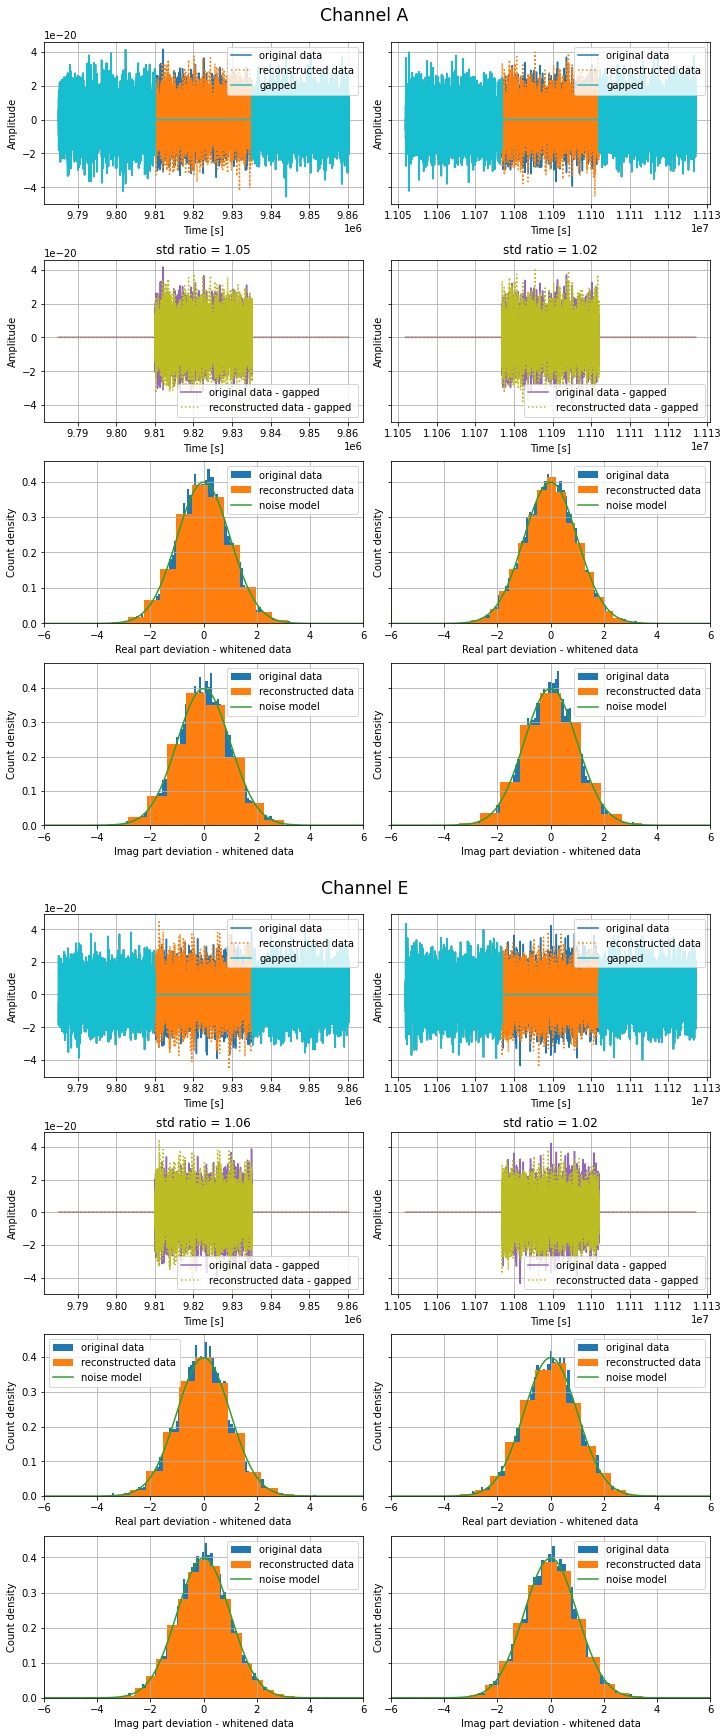

In [49]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

In [50]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

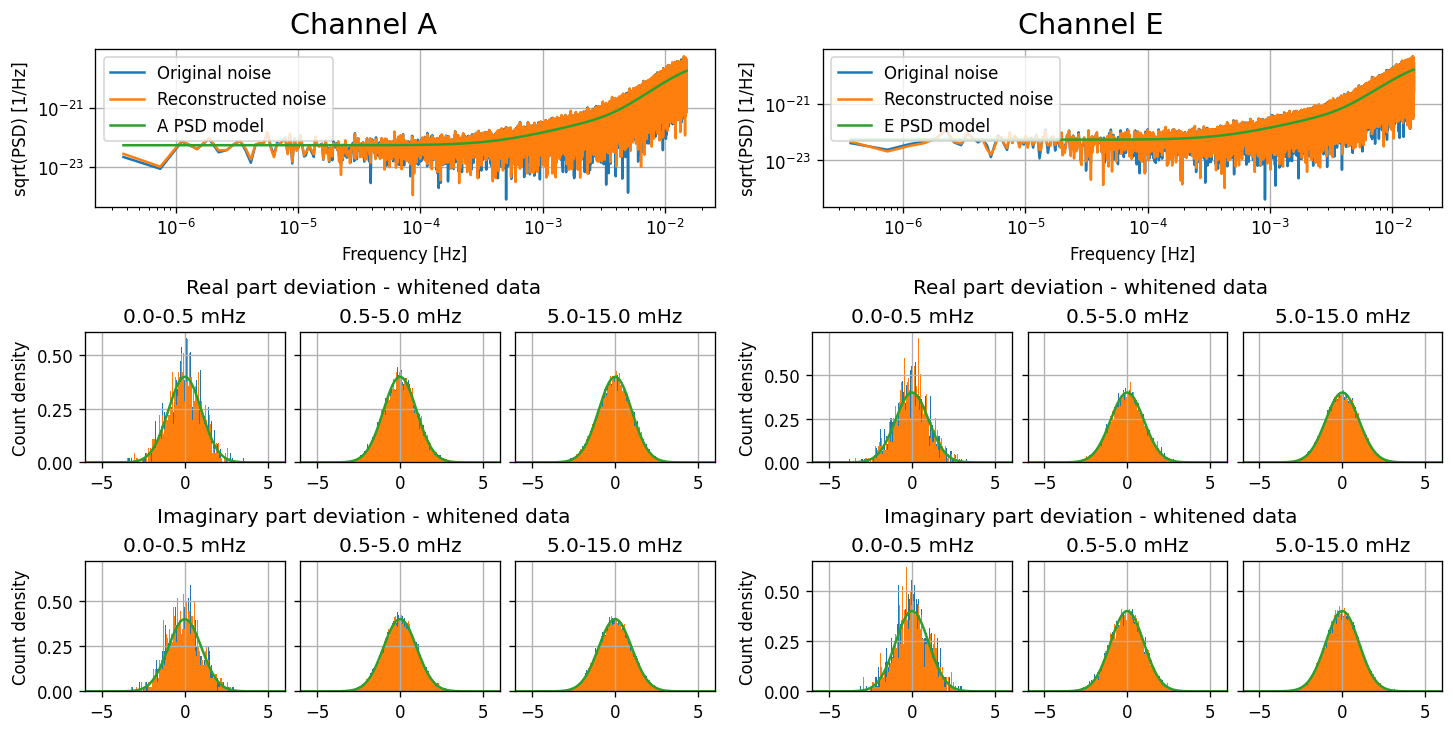

In [51]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 4: `fit_dof=6`, `fmin = f[5]`, `n_iter=10`

 `fmin` value is 1.87e-06
Instantiate imputation class for tdi channel A
Computation of autocovariance + PSD took 6.86493992805481
Computation of autocovariance + PSD took 0.24195313453674316
Computation of autocovariance + PSD took 0.235368013381958
Computation of autocovariance + PSD took 0.2405869960784912
Computation of autocovariance + PSD took 0.24219107627868652
Computation of autocovariance + PSD took 0.23958396911621094
Computation of autocovariance + PSD took 0.2516908645629883
Computation of autocovariance + PSD took 0.2326490879058838
Computation of autocovariance + PSD took 0.22789287567138672
Computation of autocovariance + PSD took 0.2220909595489502
Computation of autocovariance + PSD took 0.22609829902648926
Imputation for combination A took 15.897062063217163
Instantiate imputation class for tdi channel E
Computation of autocovariance + PSD took 6.4370880126953125
Computation of autocovariance + PSD took 0.23731303215026855
Computation of autocovariance + PSD took 0.2

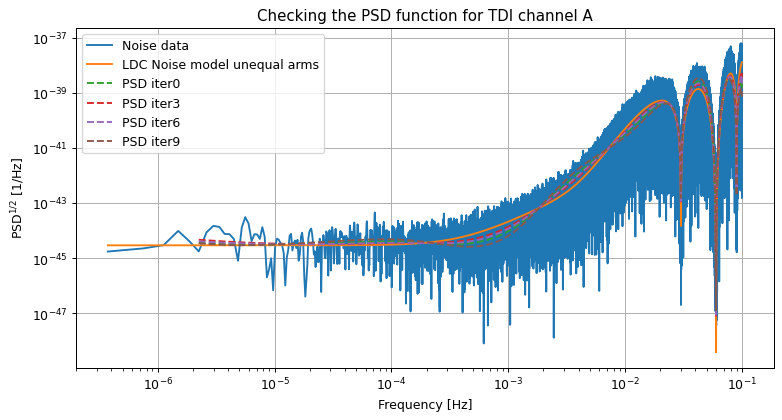

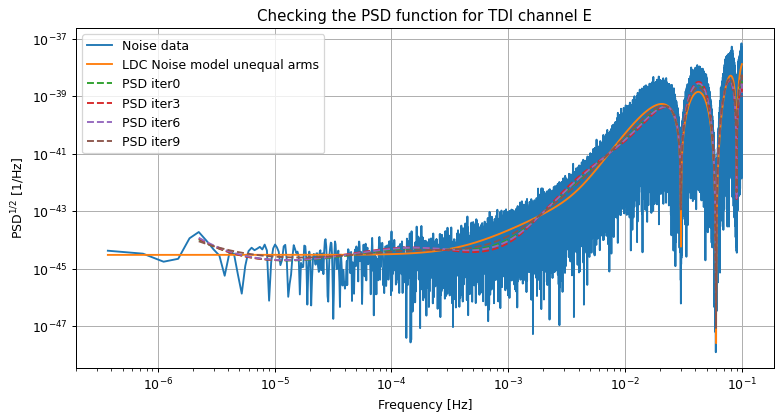

In [52]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10

# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 5
print(' `fmin` value is {:.2e}'.format(fmin))
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
#     print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    
#     print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
#     print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
#         print('Imputation iteration '+str(i))
        # Do update PSD
#         print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = psdmodel.ModelFDDataPSD
#         print('\t Instantiate PSD estimator')
        save_stdout = sys.stdout
        sys.stdout = open('trash', 'w')
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type='log_spline',
                          fit_dof=6,
                          smooth_df=4e-4,
                          fmin=fmin,
                          offset_log_fit=True)
        sys.stdout = save_stdout

#         print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
        # Re-compute of PSD-dependent terms
#         print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
#         print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
        # Update the data residuals
#         print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
        t2 = time.time()
#         print("The imputation /  PSD estimation for combination " + tdi + " in iteration "+ str(i) +" took " + str(t2-t1))
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

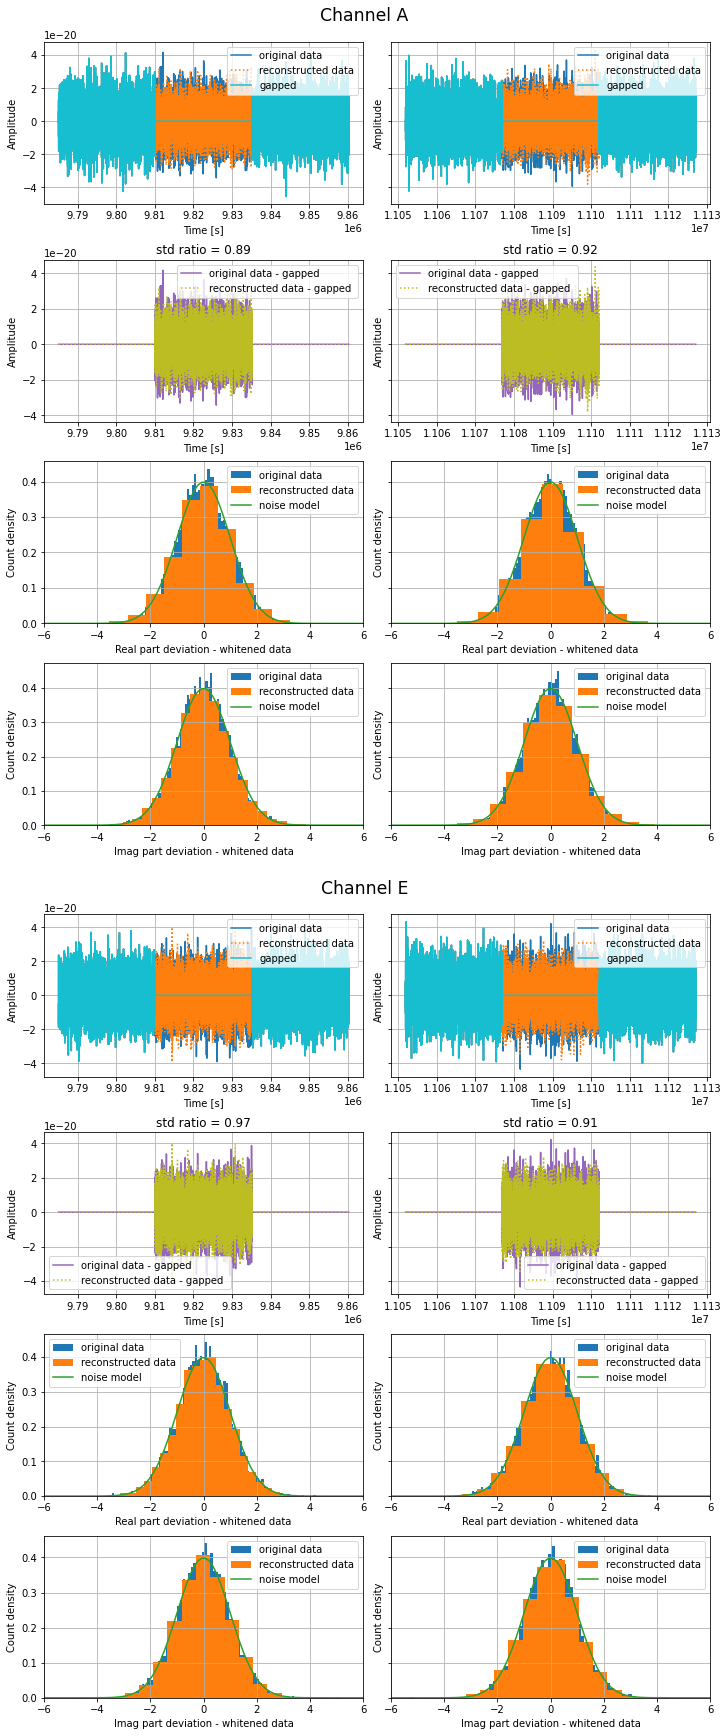

In [53]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

In [54]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

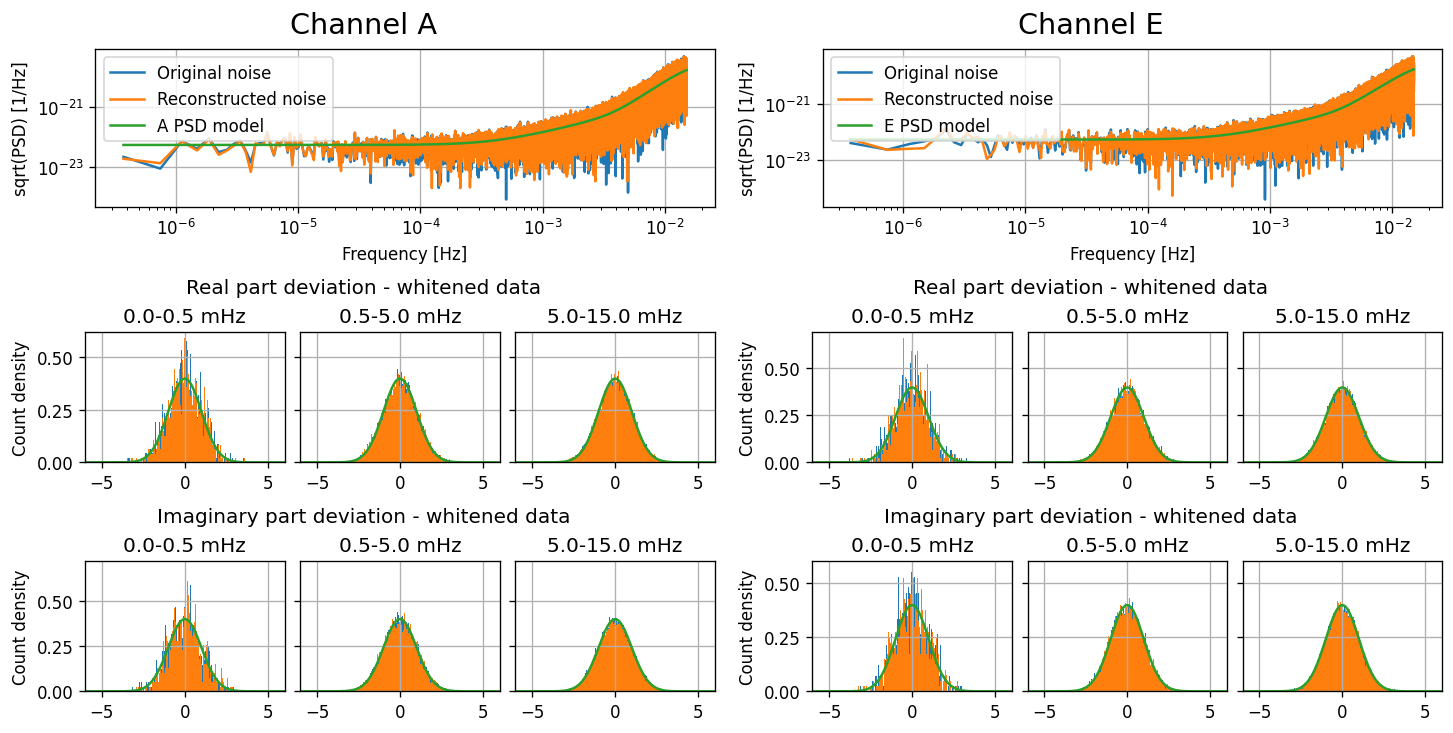

In [55]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 5: `fit_dof=6`, `fmin = f[10]`, `n_iter=10`

 `fmin` value is 3.73e-06
Instantiate imputation class for tdi channel A
Computation of autocovariance + PSD took 6.902799129486084
Computation of autocovariance + PSD took 0.2292652130126953
Computation of autocovariance + PSD took 0.2236950397491455
Computation of autocovariance + PSD took 0.2254788875579834
Computation of autocovariance + PSD took 0.22178411483764648
Computation of autocovariance + PSD took 0.2171330451965332
Computation of autocovariance + PSD took 0.21942925453186035
Computation of autocovariance + PSD took 0.21640896797180176
Computation of autocovariance + PSD took 0.22225117683410645
Computation of autocovariance + PSD took 0.23399710655212402
Computation of autocovariance + PSD took 0.24281692504882812
Imputation for combination A took 15.566686153411865
Instantiate imputation class for tdi channel E
Computation of autocovariance + PSD took 6.454758882522583
Computation of autocovariance + PSD took 0.2620079517364502
Computation of autocovariance + PSD took 0.

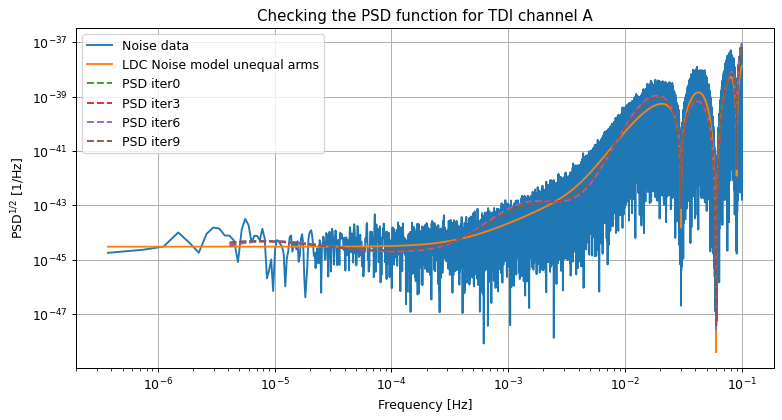

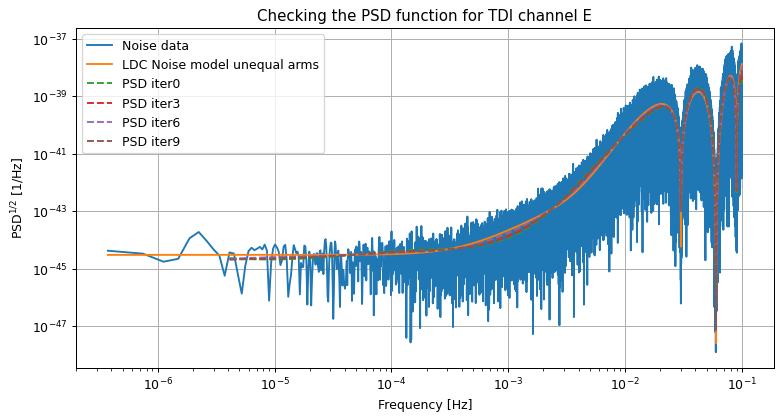

In [56]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10

# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 10
print(' `fmin` value is {:.2e}'.format(fmin))
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation

for tdi in names:
    
    t1 = time.time()
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
#     print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    
#     print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
#     print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
#         print('Imputation iteration '+str(i))
        # Do update PSD
#         print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = psdmodel.ModelFDDataPSD
#         print('\t Instantiate PSD estimator')
        save_stdout = sys.stdout
        sys.stdout = open('trash', 'w')
        
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type='log_spline',
                          fit_dof=6,
                          smooth_df=4e-4,
                          fmin=fmin,
                          offset_log_fit=True)
        sys.stdout = save_stdout

#         print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
#         Re-compute of PSD-dependent terms
#         print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
#         print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
        # Update the data residuals
#         print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
        t2 = time.time()
#         print("The imputation /  PSD estimation for combination " + tdi + " in iteration "+ str(i) +" took " + str(t2-t1))
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

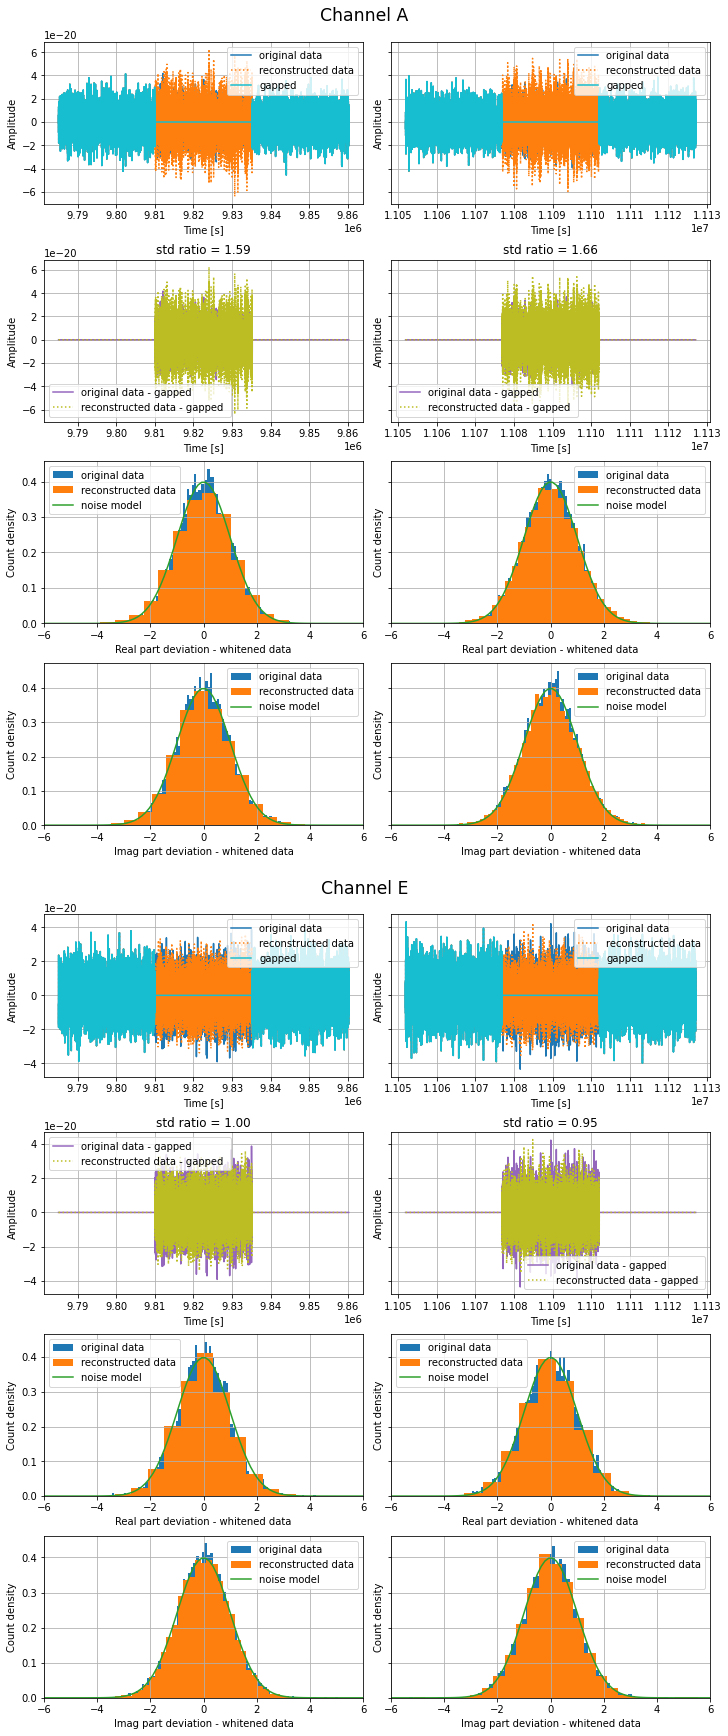

In [57]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

In [58]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

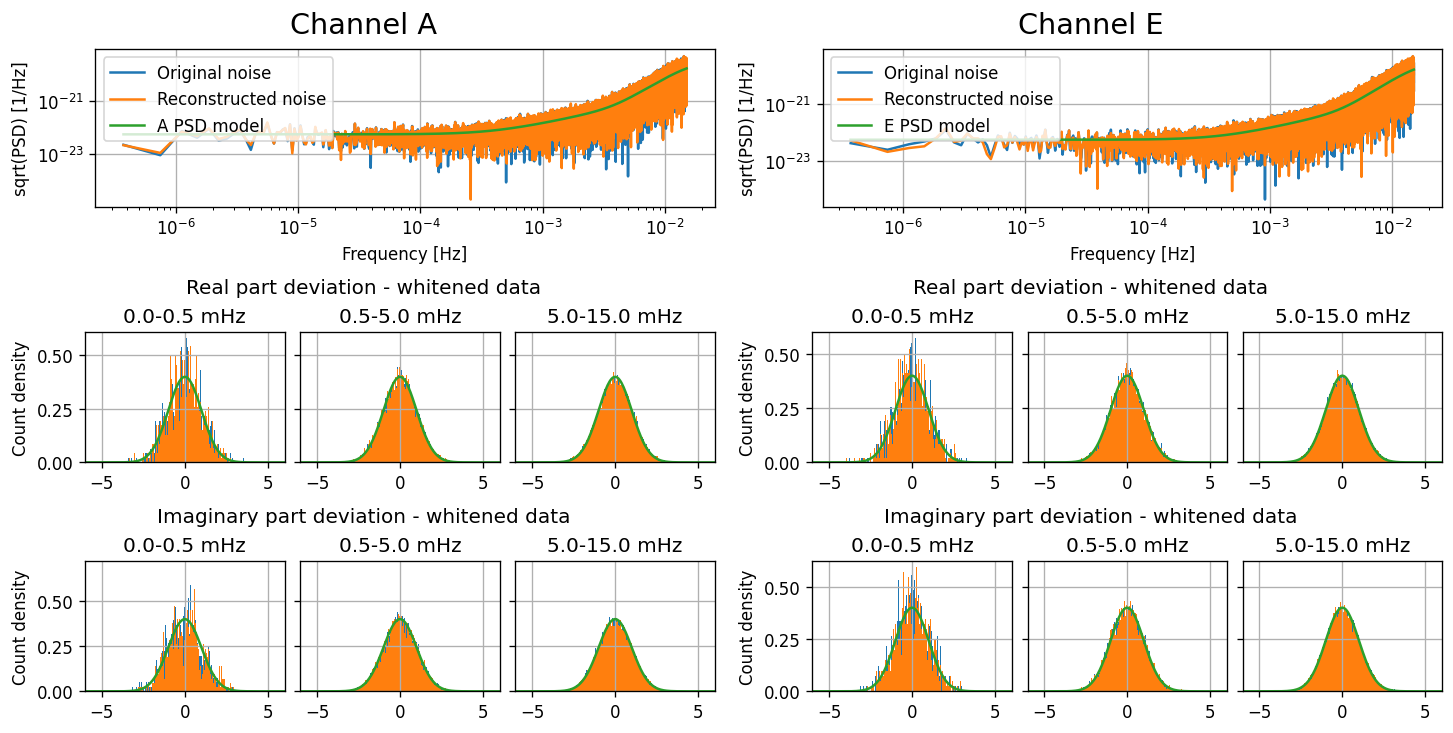

In [59]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 6: `fit_dof=6`, `k_fmin = f[20]`, `n_iter=10`

 `fmin` value is 9.34e-06
Instantiate imputation class for tdi channel A
Computation of autocovariance + PSD took 9.543033123016357
Computation of autocovariance + PSD took 0.2749149799346924
Computation of autocovariance + PSD took 0.36690187454223633
Computation of autocovariance + PSD took 0.29838109016418457
Computation of autocovariance + PSD took 0.26097798347473145
Computation of autocovariance + PSD took 0.25262999534606934
Computation of autocovariance + PSD took 0.2593369483947754
Computation of autocovariance + PSD took 0.25808215141296387
Computation of autocovariance + PSD took 0.2538869380950928
Computation of autocovariance + PSD took 0.25179100036621094
Computation of autocovariance + PSD took 0.27825188636779785
Imputation for combination A took 20.999044179916382
Instantiate imputation class for tdi channel E
Computation of autocovariance + PSD took 10.436758995056152
Computation of autocovariance + PSD took 0.29097580909729004
Computation of autocovariance + PSD took

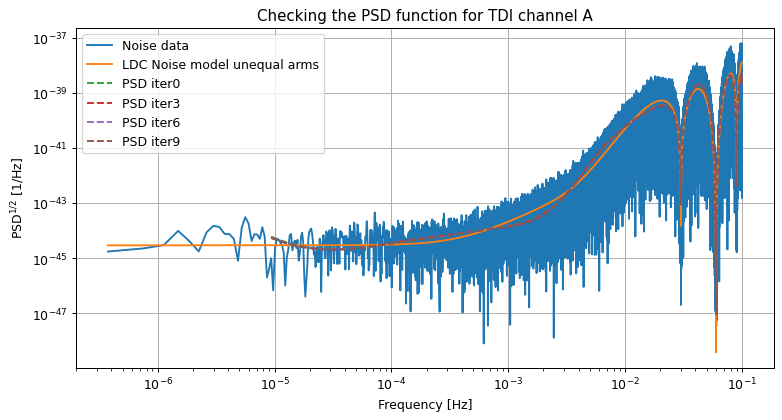

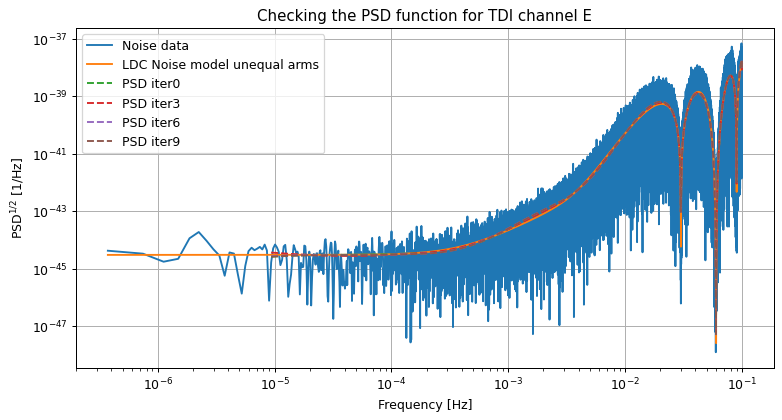

In [69]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10

# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 25
print(' `fmin` value is {:.2e}'.format(fmin))
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
#     print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    
#     print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
#     print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
#         print('Imputation iteration '+str(i))
        # Do update PSD
#         print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = psdmodel.ModelFDDataPSD
#         print('\t Instantiate PSD estimator')  
        save_stdout = sys.stdout
        sys.stdout = open('trash', 'w')
        
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type='log_spline',
                          fit_dof=6,
                          smooth_df=4e-4,
                          fmin=fmin,
                          offset_log_fit=True)
        sys.stdout = save_stdout

#         print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
        # Re-compute of PSD-dependent terms
#         print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
#         print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
        # Update the data residuals
#         print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
        t2 = time.time()
#         print("The imputation /  PSD estimation for combination " + tdi + " in iteration "+ str(i) +" took " + str(t2-t1))
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

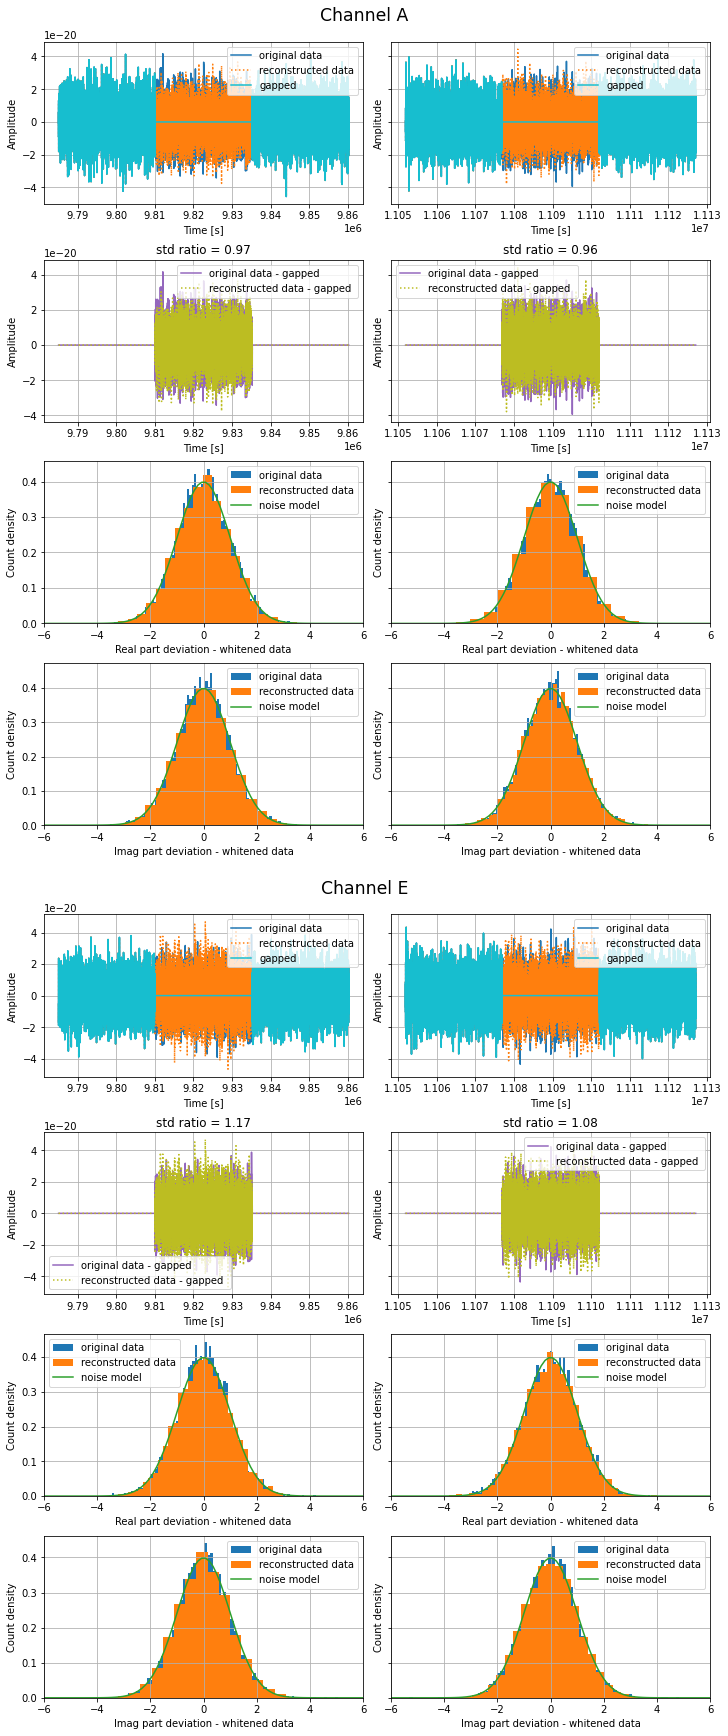

In [70]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

In [71]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

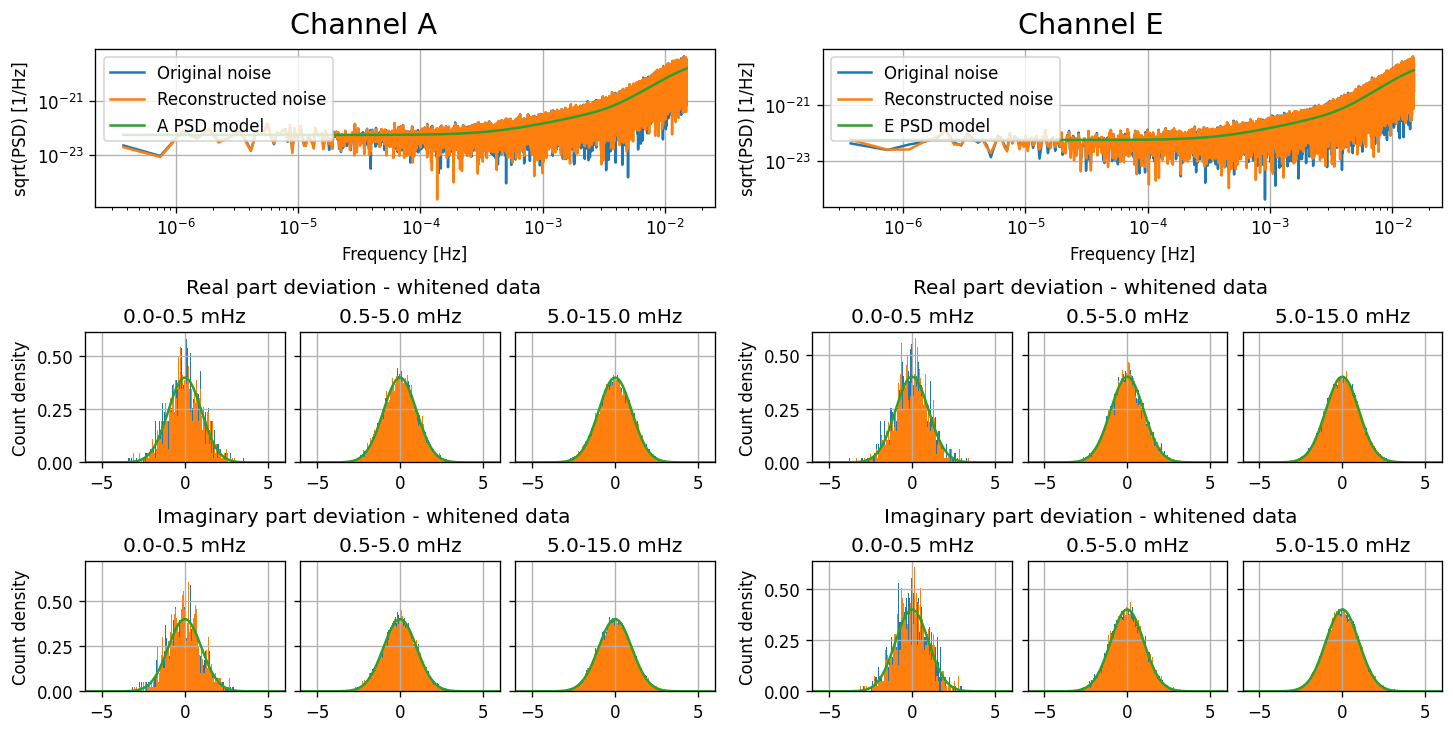

In [72]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 7: `fit_dof=15`, `fmin = f[5]`, `n_iter=10`

 `fmin` value is 1.87e-06
Instantiate imputation class for tdi channel A
Computation of autocovariance + PSD took 6.972845077514648
Computation of autocovariance + PSD took 0.22987127304077148
Computation of autocovariance + PSD took 0.21997594833374023
Computation of autocovariance + PSD took 0.22633767127990723
Computation of autocovariance + PSD took 0.21712112426757812
Computation of autocovariance + PSD took 0.21975493431091309
Computation of autocovariance + PSD took 0.22223997116088867
Computation of autocovariance + PSD took 0.2219088077545166
Computation of autocovariance + PSD took 0.22145509719848633
Computation of autocovariance + PSD took 0.24590182304382324
Computation of autocovariance + PSD took 0.21976089477539062
Imputation for combination A took 15.845574855804443
Instantiate imputation class for tdi channel E
Computation of autocovariance + PSD took 6.498391151428223
Computation of autocovariance + PSD took 0.22562098503112793
Computation of autocovariance + PSD too

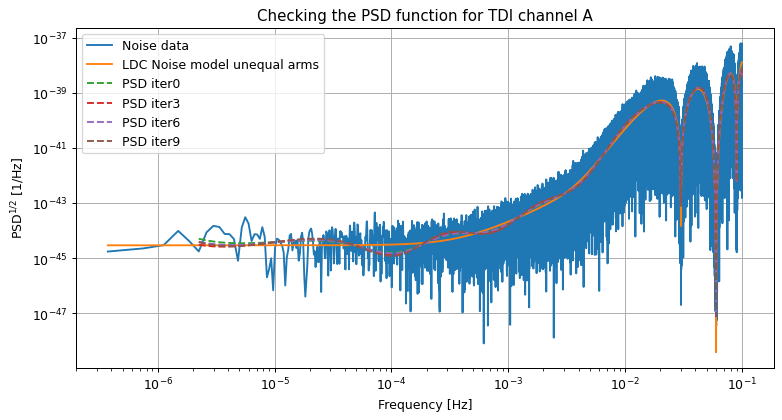

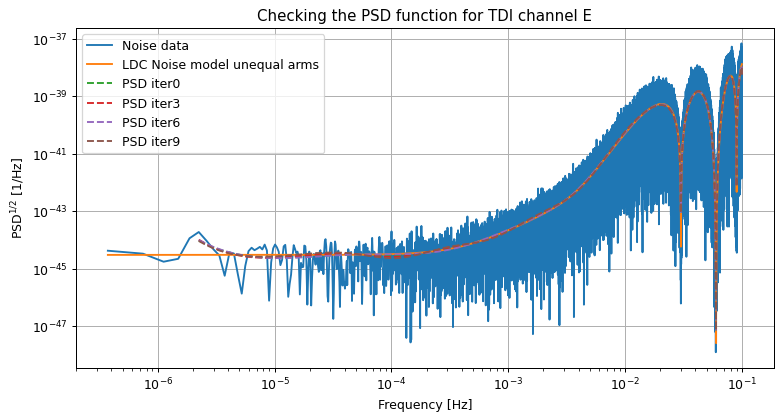

In [64]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10

# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 5
print(' `fmin` value is {:.2e}'.format(fmin))
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
#     print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    
#     print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
#     print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
#         print('Imputation iteration '+str(i))
        # Do update PSD
#         print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = psdmodel.ModelFDDataPSD
#         print('\t Instantiate PSD estimator')
        save_stdout = sys.stdout
        sys.stdout = open('trash', 'w')
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type='log_spline',
                          fit_dof=10,
                          smooth_df=4e-4,
                          fmin=fmin,
                          offset_log_fit=True)
        sys.stdout = save_stdout

#         print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
        # Re-compute of PSD-dependent terms
#         print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
#         print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
        # Update the data residuals
#         print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
        t2 = time.time()
#         print("The imputation /  PSD estimation for combination " + tdi + " in iteration "+ str(i) +" took " + str(t2-t1))
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

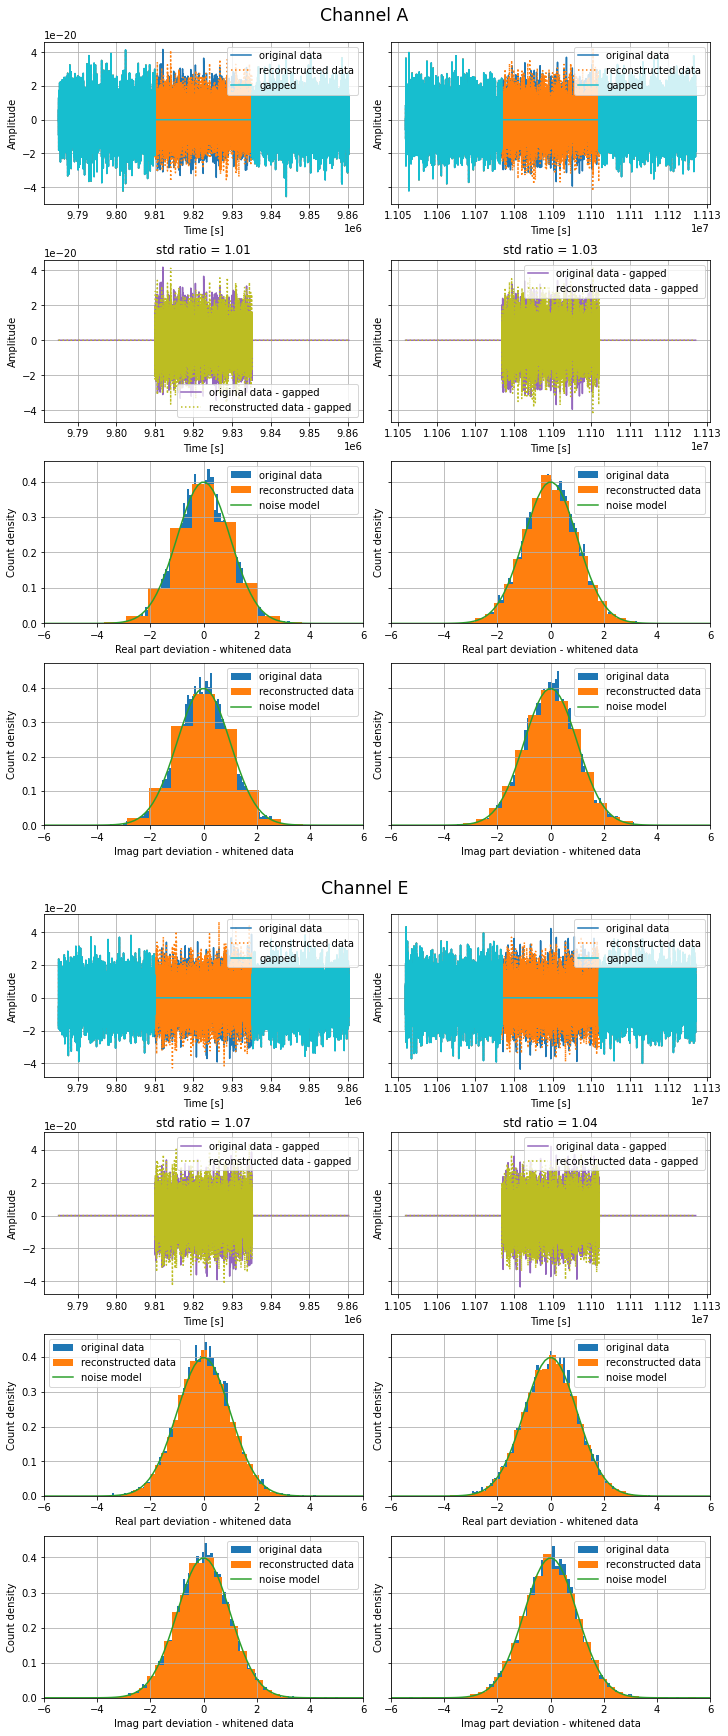

In [65]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

In [66]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

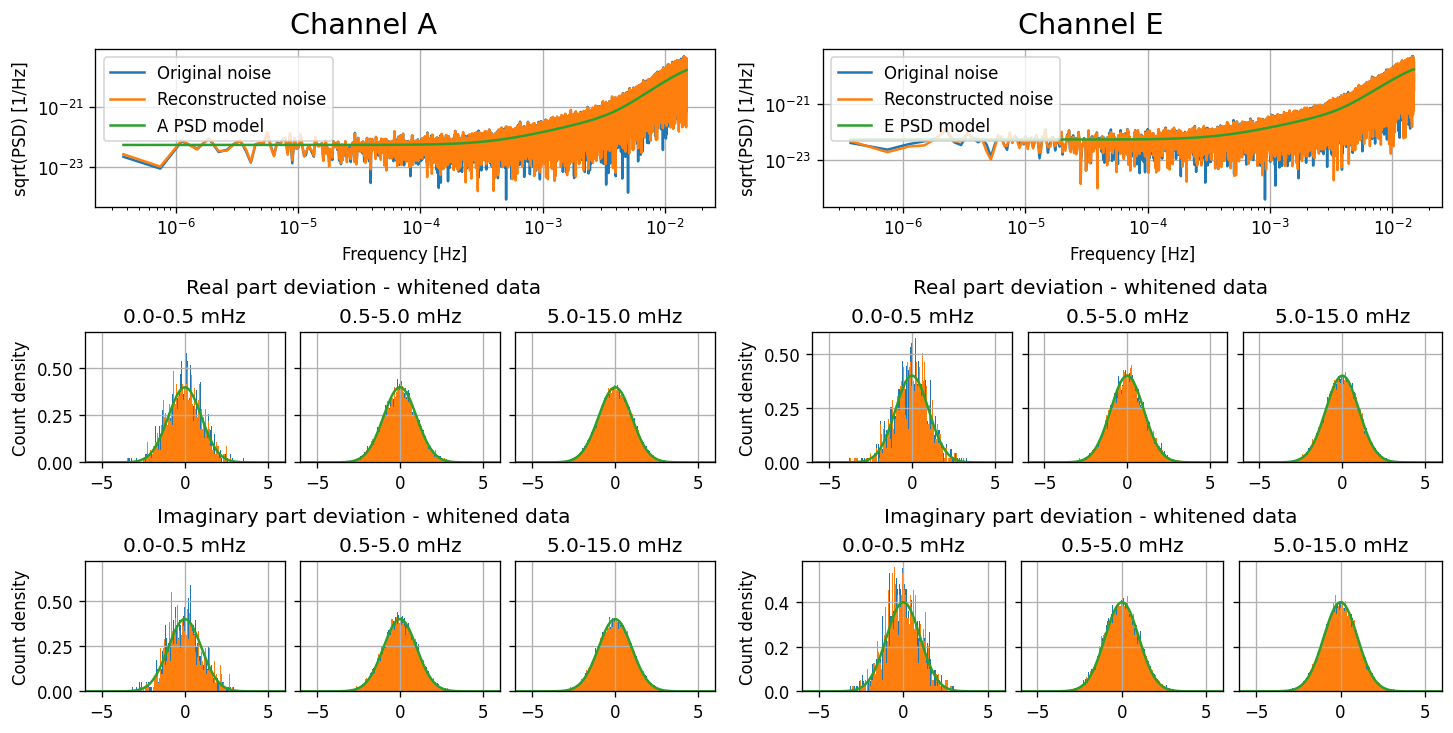

In [67]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)